## Project 2: Ames Housing Prices & Kaggle Challenge

### Problem Statement

In this analysis, I set out to build a linear regression model that can predict home prices in Ames, Iowa. The train data set that came as part of the Kaggle Challenge had detailed records of 2050 home sales between 2006 - 2010 with 79 features describing both exterior and interior characteristics of each home.

Given the wide scope of features to examine and consider, some of the difficult challenges with this analysis was figuring out the best method to select which features to focus on, how to properly clean and transform the data in a way that is compatible to fit in a linear regression model, and how to properly interpret the findings.

In essence, the overacrching theme and goal of this analysis is to answer these two key questions:

* Which features have the most impact determining housing prices?
* Which model is most optimal to predict housing prices?

As a side note, I chose to specifically focus on R2, MSE, and RMSE linear regression metrics throughout the analysis to evaluate my model. While I could have measured and compared other metrics, I felt these three scores would be sufficient enough to determine whether the model is performing at a high level. A particular attention was focused on RMSE as the Kaggle competition was measured based on RMSE.

### Content

**[Data Cleaning](#Data-Cleaning-Process)**

**[EDA](#EDA)**

**[Setting the Stage for Linear Regression](#Setting-Up-for-Linear-Regression)**

**[Ridge](#Ridge)**

**[Lasso](#Lasso)**

**[ElasticNet](#ElasticNet)**

**[Conclusion and Recommendations](#Conclusion-and-Recommendations)**

**[Kaggle Submission](#Submission-Preparation)**



### Data Dictionary

|Feature|Type|Table|Description|
|---|---|---|---|
|**has_garage**|int|ames|Binary 1 or 0 if home has a garage|
|**has_pool**|int|ames|Binary 1 or 0 if home has a pool|
|**has_fireplace**|int|ames|Binary 1 or 0 if home has a fireplace|
|**has_porch**|int|ames|Binary 1 or 0 if home has a porch|
|**has_basement**|int|ames|Binary 1 or 0 if home has a basement|
|**Bsmt Bath**|int|ames|Sum of Bsmt Full Bath + 0.5 * Bsmt Half Bath|
|**Total Bath**|int|ames|Sum of Full Bath + 0.5 * Half Bath|
|**Alpha**|float|Metrics Summary|Optimal Alpha Score for Ridge, Lasso, ElasticNet|
|**R2**|float|Metrics Summary|Coeffcient of Determination|
|**MSE**|float|Metrics Summary|Mean Squared Error (Log Scale)|
|**RMSE**|float|Metrics Summary|SAT Root Mean Squared Error (Log Scale)|
|**MSE_exp**|float|Metrics Summary|Mean Squared Error (Exponentiated)|
|**RMSE_exp**|float|Metrics Summary|Root Mean Squared Error (Exponentiated)|


To preserve the naming convention of the original train data set, I did not alter the feature names in any way. Any new features that were engineered as interative terms are combinations of the features from the original train data set. Details for those features can be found in the [Data Dictionary for the Ames Housing Data.](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

### Data Sources:

* Ames Housing Train Data
* Ames Housing Test Data (Used for Kaggle submission)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# Reading in the ames train data set.

ames = pd.read_csv('../datasets/train.csv')

pd.options.display.max_columns = None # Displays all dataframe columns

### Data Cleaning Process

While cumbersome, I alloted a significant amount of time to carefully examine and review each features in the dataset. This was necessary because the dataset contains many different types of variables (continuous, discrete, categorical that are both ordinal and nominal in nature). In addition, certain columns were missing values which required proper data quality treatment as necessary (replace nulls with 0, NA, or some other value that makes the most sense).

Certain variables made sense to combine as one variable. For instance, bsmt full bath and bsmt half bath were added together as just total bsmt bath.

For ordinal variables, I created scatterplots for each of them and examined their relationship to sale price. If it was visually clear there was a clear distinction, I decided to assign them to a numeric scale of my choosing. If ordering didn't seem to matter as much, I chose to leave them as ordinal variables and convert them to dummy variables.

In [3]:
ames.shape

(2051, 81)

In [4]:
ames.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
0        RRAe        Norm      1Fam      2Story             6             8   
1        Norm        Norm      1Fam      2Story             7             5   
2        Norm        Norm      1Fam      1Story             5             7   
3        Norm        Norm      1Fam      2Story             5             5   
4        Norm        Norm      1Fam      1.5Fin             6             8   

   Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st Exterior 2nd  \
0        1976            2005      Gable   CompShg      HdBoard      Plywood   
1        1996            1997      Gable   CompShg      VinylSd      VinylSd   
2        1953            2007      Gable   CompShg      VinylSd      VinylSd   
3        2006            2007      Gable   CompShg      VinylSd      VinylSd   
4        1900            1993      Gable   CompShg      Wd Sdng      Plywood   

  Mas Vnr Type  Mas Vnr Area Exter Qual Exter Cond Foundation Bsmt Qual  \
0      BrkFace         289.0         Gd         TA     CBlock        TA   
1      BrkFace         132.0         Gd         TA      PConc        Gd   
2         None           0.0         TA         Gd     CBlock        TA   
3         None           0.0         TA         TA      PConc        Gd   
4         None           0.0         TA         TA      PConc        Fa   

  Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1 BsmtFin Type 2  \
0        TA            No            GLQ         533.0            Unf   
1        TA            No            GLQ         637.0            Unf   
2        TA            No            GLQ         731.0            Unf   
3        TA            No            Unf           0.0            Unf   
4        Gd            No            Unf           0.0            Unf   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF Heating Heating QC Central Air  \
0           0.0        192.0          725.0    GasA         Ex           Y   
1           0.0        276.0          913.0    GasA         Ex           Y   
2           0.0        326.0         1057.0    GasA         TA           Y   
3           0.0        384.0          384.0    GasA         Gd           Y   
4           0.0        676.0          676.0    GasA         TA           Y   

  Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0      SBrkr         725         754                0         1479   
1      SBrkr         913        1209                0         2122   
2      SBrkr        1057           0                0         1057   
3      SBrkr         744         700                0         1444   
4      SBrkr         831         614                0         1445   

   Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2  

In [5]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [6]:
# Id - Dropping this column as this seems unnecessary.

ames.drop(columns='Id', inplace=True)

In [7]:
# PID - Dropping this as well.

ames.drop(columns='PID', inplace=True)

In [8]:
# MS SubClass - Pandas is reading this as a numeric value. However, from the data dictionary, I can see that this variable is actually nominal.

ames['MS SubClass'] = ames['MS SubClass'].astype(str)

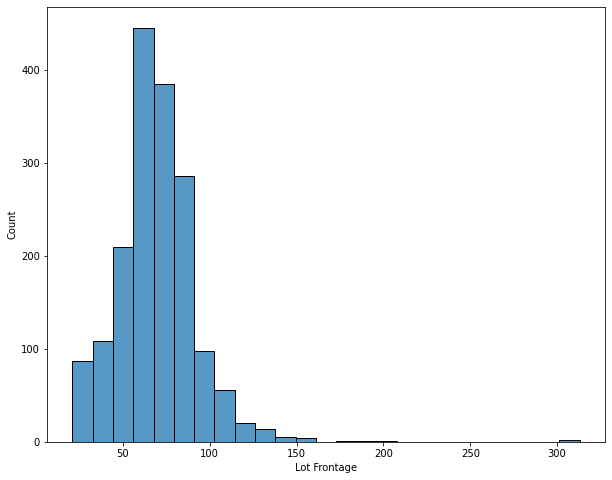

In [9]:
# Lot frontage is missing in a lot of rows. Given the distribution, I'm going to replace the nulls with the median value.

plt.figure(figsize=(10,8))
sns.histplot(ames['Lot Frontage'], bins=25);

ames.loc[ames['Lot Frontage'].isnull(),'Lot Frontage'] = ames['Lot Frontage'].mean()

In [10]:
# Alley - Replaceing null with 'NA'

ames.loc[ames['Alley'].isnull(),'Alley'] = 'No Alley'

In [11]:
ames['Mas Vnr Type'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [12]:
# In Mas Vnr Type, replacing NaN with 'None'

ames.loc[ames['Mas Vnr Type'].isnull(), 'Mas Vnr Type'] = 'None'

In [13]:
# In Mas Vnr Area, changing it to 0.

ames.loc[ames['Mas Vnr Area'].isnull(),'Mas Vnr Area']=0

In [14]:
# In Bsmt Qual, replacing null with 'NA'

ames.loc[ames['Bsmt Qual'].isnull(),'Bsmt Qual'] = 'NA'

In [15]:
# In Bsmt Cond, replacing null with 'NA'

ames.loc[ames['Bsmt Cond'].isnull(),'Bsmt Cond'] = 'NA'

In [16]:
# In Bsmt Exp, replacing null with 'NA'

ames.loc[ames['Bsmt Exposure'].isnull(),'Bsmt Exposure'] = 'NA'

In [17]:
# In BsmtFin Type 1, replacing null with 'NA'

ames.loc[ames['BsmtFin Type 1'].isnull(),'BsmtFin Type 1'] = 'NA'

In [18]:
# In BsmtFin SF 1, replacing to 0.

ames.loc[ames['BsmtFin SF 1'].isnull(),'BsmtFin SF 1'] = 0

In [19]:
# In BsmtFin Type 2, replacing null with 'NA'

ames.loc[ames['BsmtFin Type 2'].isnull(),'BsmtFin Type 2'] = 'NA'

In [20]:
# In BsmtFin SF 2, replacing to 0.

ames.loc[ames['BsmtFin SF 2'].isnull(),'BsmtFin SF 2'] = 0

In [21]:
# In Bsmt Unf SF, replacing to 0.

ames.loc[ames['Bsmt Unf SF'].isnull(),'Bsmt Unf SF'] = 0

In [22]:
# In Total Bsmt SF, replacing to 0.

ames.loc[ames['Total Bsmt SF'].isnull(),'Total Bsmt SF'] = 0

In [23]:
# Replacing null in Bsmt Full Bath with 0

ames.loc[ames['Bsmt Full Bath'].isnull(),'Bsmt Full Bath'] = 0

In [24]:
# Replacing null in Bsmt Half Bath with 0

ames.loc[ames['Bsmt Half Bath'].isnull(),'Bsmt Half Bath'] = 0

In [25]:
# In Fireplace Qu, replacing null with 'NA'

ames.loc[ames['Fireplace Qu'].isnull(),'Fireplace Qu'] = 'NA'

In [26]:
# In Garage Type, replacing null with 'NA'

ames.loc[ames['Garage Type'].isnull(),'Garage Type'] = 'NA'

In [27]:
# Replacing null in Garage Yr Blt with 0

ames.loc[ames['Garage Yr Blt'].isnull(),'Garage Yr Blt'] = 0

In [28]:
# In Garage Finish, replacing null with 'NA'

ames.loc[ames['Garage Finish'].isnull(),'Garage Finish'] = 'NA'

In [29]:
# Replacing null in Garage Yr Blt with 0

ames.loc[ames['Garage Cars'].isnull(),'Garage Cars'] = 0

In [30]:
# In Garage Area, replacing to 0.

ames.loc[ames['Garage Area'].isnull(),'Garage Area'] = 0

In [31]:
# In Garage Qual, replacing null with 'NA'

ames.loc[ames['Garage Qual'].isnull(),'Garage Qual'] = 'NA'

In [32]:
# In Garage Qual, replacing null with 'NA'

ames.loc[ames['Garage Cond'].isnull(),'Garage Cond'] = 'NA'

In [33]:
# In Garage Qual, replacing null with 'NA'

ames.loc[ames['Pool QC'].isnull(),'Pool QC'] = 'NA'

In [34]:
# In Garage Qual, replacing null with 'NA'

ames.loc[ames['Fence'].isnull(),'Fence'] = 'NA'

In [35]:
# In Garage Type, replacing null with 'NA'

ames.loc[ames['Misc Feature'].isnull(),'Misc Feature'] = 'NA'

In [36]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2051 non-null   object 
 1   MS Zoning        2051 non-null   object 
 2   Lot Frontage     2051 non-null   float64
 3   Lot Area         2051 non-null   int64  
 4   Street           2051 non-null   object 
 5   Alley            2051 non-null   object 
 6   Lot Shape        2051 non-null   object 
 7   Land Contour     2051 non-null   object 
 8   Utilities        2051 non-null   object 
 9   Lot Config       2051 non-null   object 
 10  Land Slope       2051 non-null   object 
 11  Neighborhood     2051 non-null   object 
 12  Condition 1      2051 non-null   object 
 13  Condition 2      2051 non-null   object 
 14  Bldg Type        2051 non-null   object 
 15  House Style      2051 non-null   object 
 16  Overall Qual     2051 non-null   int64  
 17  Overall Cond  

In [37]:
ames.head()

MS SubClass MS Zoning  Lot Frontage  Lot Area Street     Alley Lot Shape  \
0          60        RL       69.0552     13517   Pave  No Alley       IR1   
1          60        RL       43.0000     11492   Pave  No Alley       IR1   
2          20        RL       68.0000      7922   Pave  No Alley       Reg   
3          60        RL       73.0000      9802   Pave  No Alley       Reg   
4          50        RL       82.0000     14235   Pave  No Alley       IR1   

  Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1  \
0          Lvl    AllPub    CulDSac        Gtl       Sawyer        RRAe   
1          Lvl    AllPub    CulDSac        Gtl      SawyerW        Norm   
2          Lvl    AllPub     Inside        Gtl        NAmes        Norm   
3          Lvl    AllPub     Inside        Gtl       Timber        Norm   
4          Lvl    AllPub     Inside        Gtl      SawyerW        Norm   

  Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  Year Built  \
0        Norm      1Fam      2Story             6             8        1976   
1        Norm      1Fam      2Story             7             5        1996   
2        Norm      1Fam      1Story             5             7        1953   
3        Norm      1Fam      2Story             5             5        2006   
4        Norm      1Fam      1.5Fin             6             8        1900   

   Year Remod/Add Roof Style Roof Matl Exterior 1st Exterior 2nd Mas Vnr Type  \
0            2005      Gable   CompShg      HdBoard      Plywood      BrkFace   
1            1997      Gable   CompShg      VinylSd      VinylSd      BrkFace   
2            2007      Gable   CompShg      VinylSd      VinylSd         None   
3            2007      Gable   CompShg      VinylSd      VinylSd         None   
4            1993      Gable   CompShg      Wd Sdng      Plywood         None   

   Mas Vnr Area Exter Qual Exter Cond Foundation Bsmt Qual Bsmt Cond  \
0         289.0         Gd         TA     CBlock        TA        TA   
1         132.0         Gd         TA      PConc        Gd        TA   
2           0.0         TA         Gd     CBlock        TA        TA   
3           0.0         TA         TA      PConc        Gd        TA   
4           0.0         TA         TA      PConc        Fa        Gd   

  Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  \
0            No            GLQ         533.0            Unf           0.0   
1            No            GLQ         637.0            Unf           0.0   
2            No            GLQ         731.0            Unf           0.0   
3            No            Unf           0.0            Unf           0.0   
4            No            Unf           0.0            Unf           0.0   

   Bsmt Unf SF  Total Bsmt SF Heating Heating QC Central Air Electrical  \
0        192.0          725.0    GasA         Ex           Y      SBrkr   
1        276.0          913.0    GasA         Ex           Y      SBrkr   
2        326.0         1057.0    GasA         TA           Y      SBrkr   
3        384.0          384.0    GasA         Gd           Y      SBrkr   
4        676.0          676.0    GasA         TA           Y      SBrkr   

   1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  \
0         725         754                0         1479             0.0   
1         913        1209                0         2122             1.0   
2        1057           0                0         1057             1.0   
3         744         700                0         1444             0.0   
4         831         614                0         1445             0.0   

   Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  Kitchen AbvGr  \
0             0.0          2          1              3              1   
1             0.0          2          1              4              1   
2             0.0          1          0              3              1   
3             0.0          2  

In [38]:
# Adding indicators for basement, garage, fireplace, pool, porch
# Combining basement bath, total bath

ames['has_garage'] = ames['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
ames['has_pool'] = ames['Pool Area'].apply(lambda x:1 if x>0 else 0)
ames['has_fireplace'] = ames['Fireplaces'].apply(lambda x:1 if x>0 else 0)
ames['has_porch'] = ames['Open Porch SF'].apply(lambda x:1 if x>0 else 0)
ames['has_basement'] = ames['Total Bsmt SF'].apply(lambda x:1 if x>0 else 0)

ames['Bsmt Bath'] = ames['Bsmt Full Bath'] + 0.5*ames['Bsmt Half Bath']
ames['Total Bath'] = ames['Full Bath'] + 0.5*ames['Half Bath']

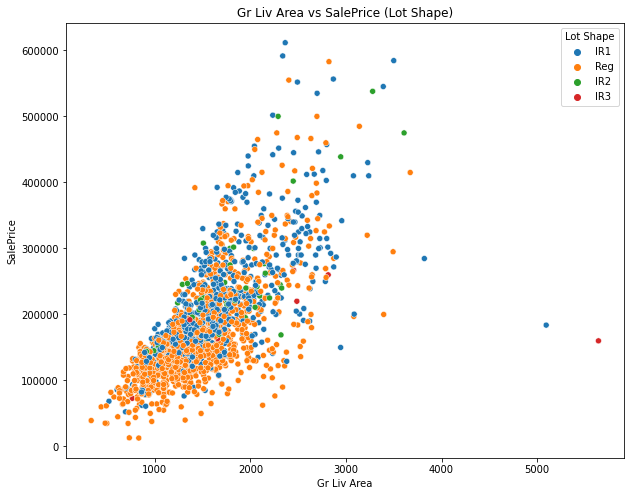

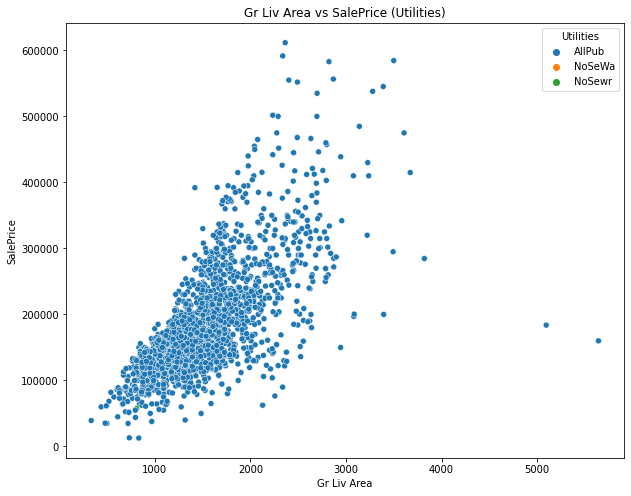

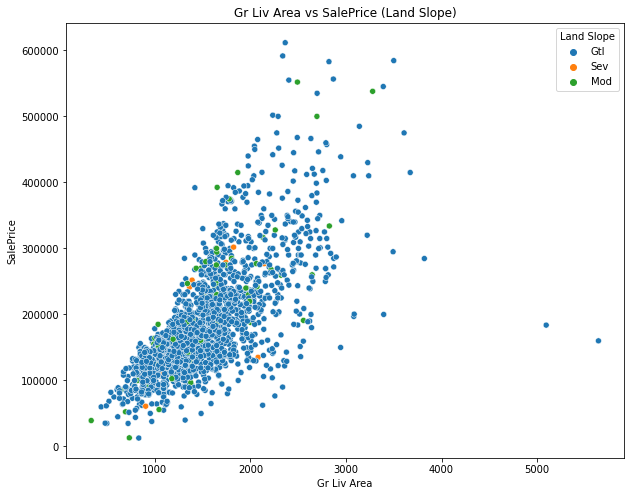

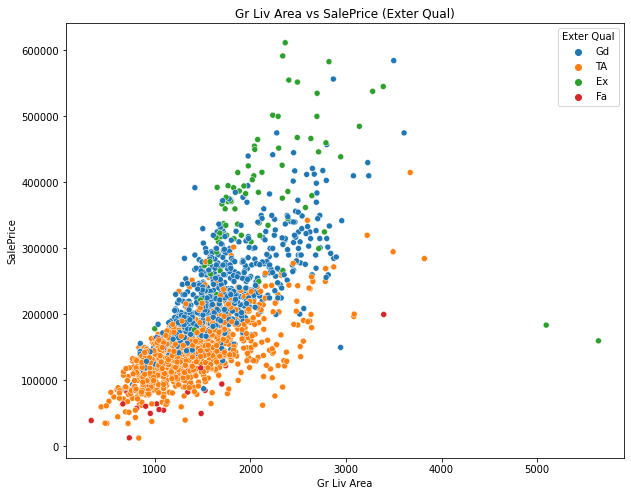

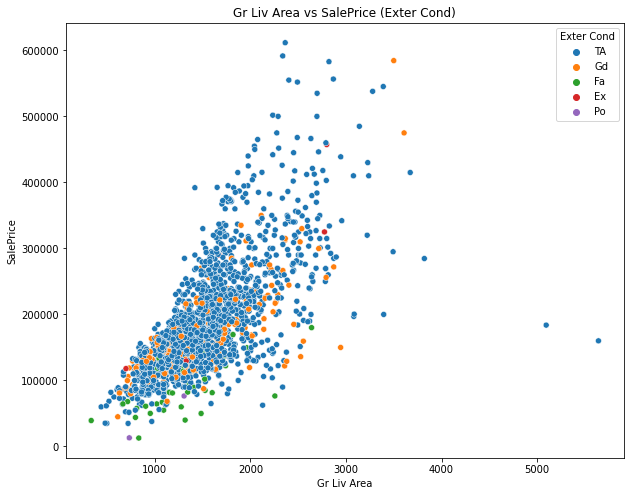

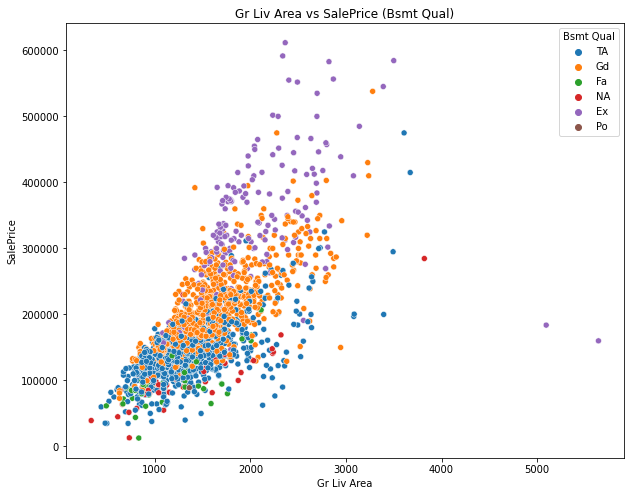

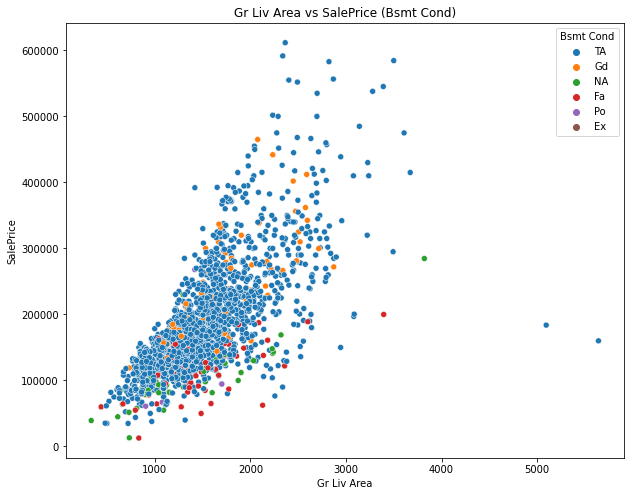

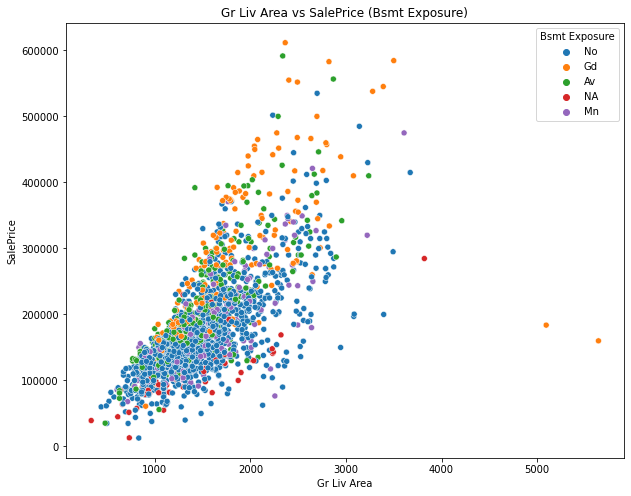

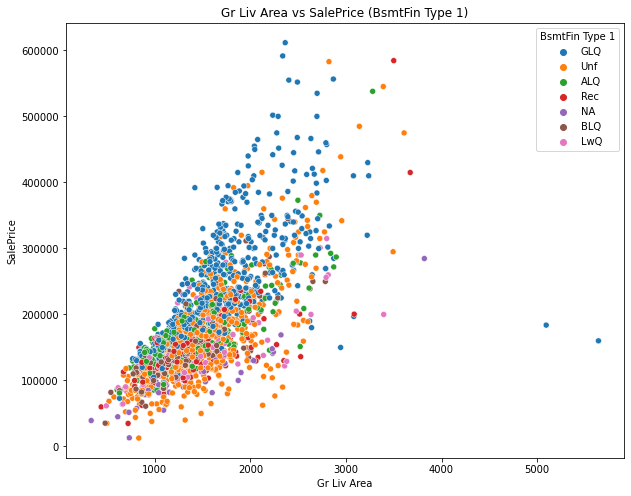

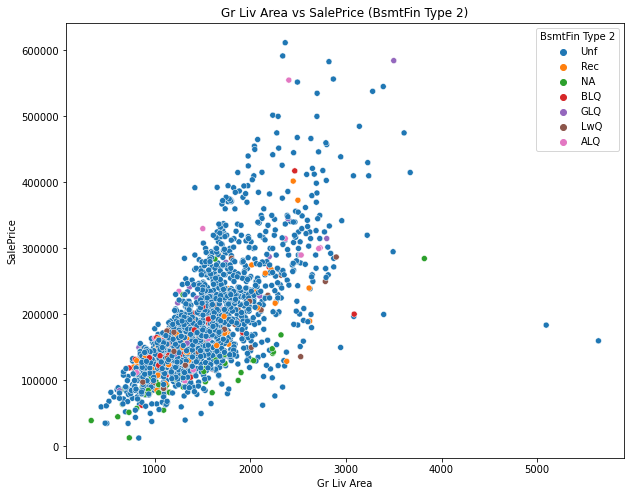

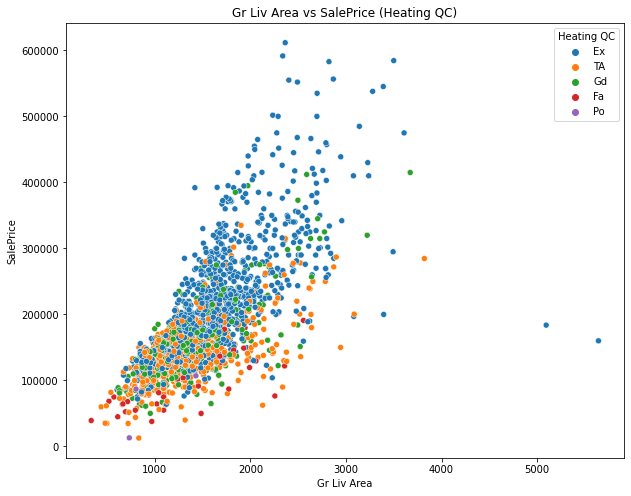

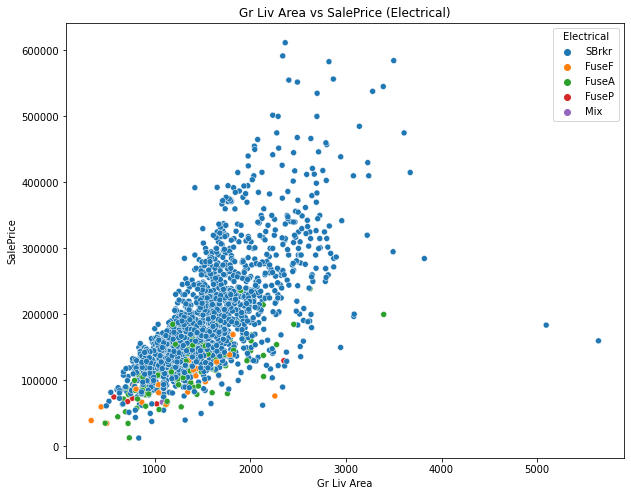

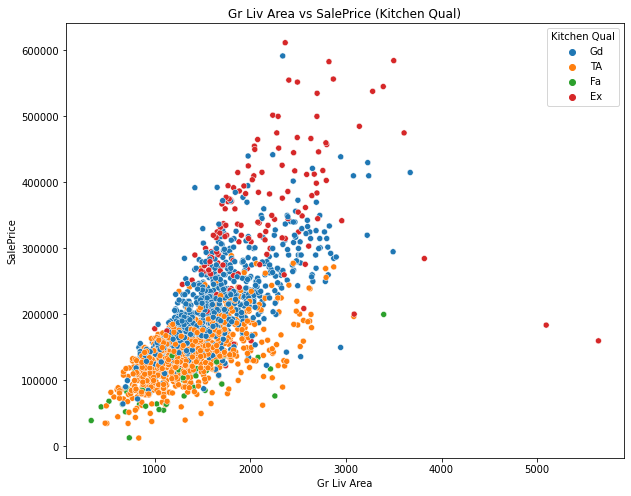

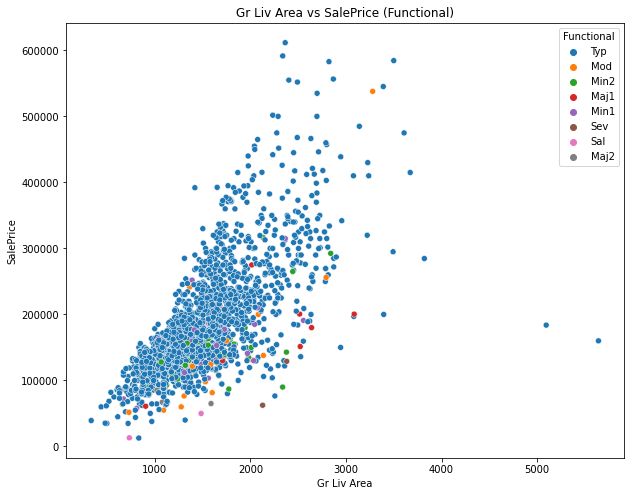

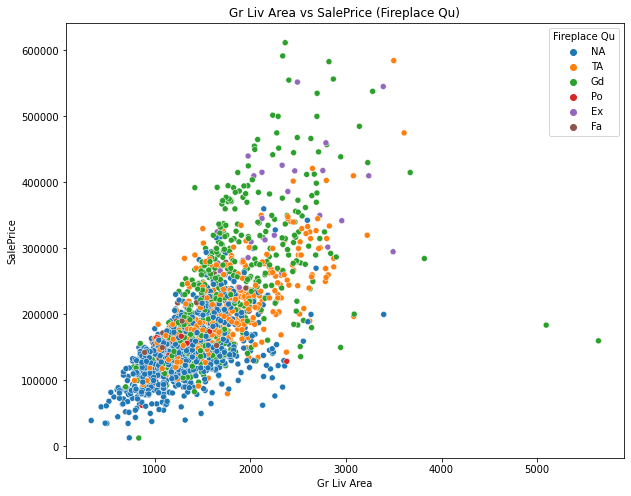

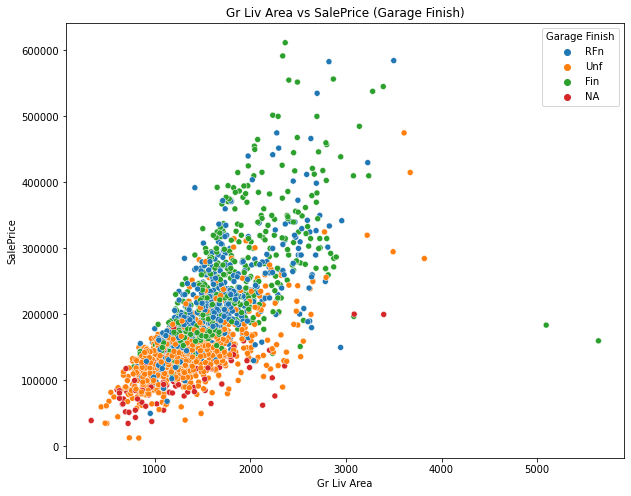

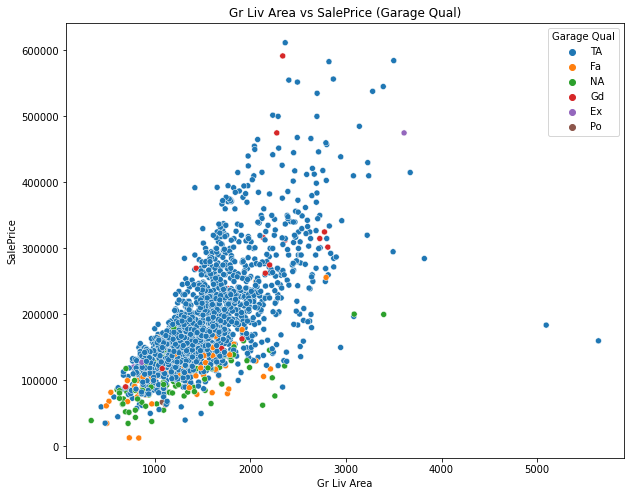

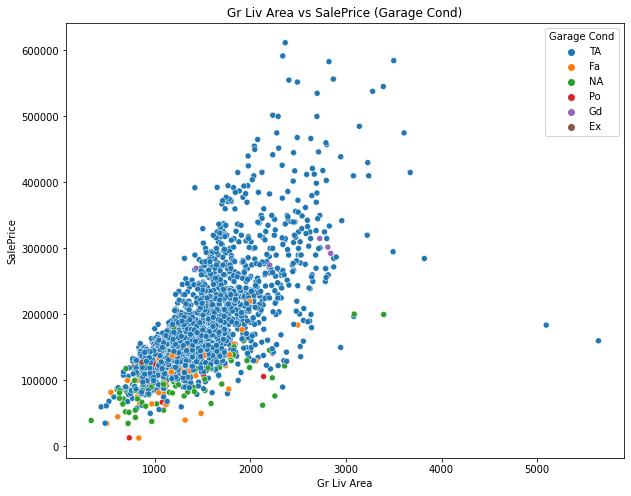

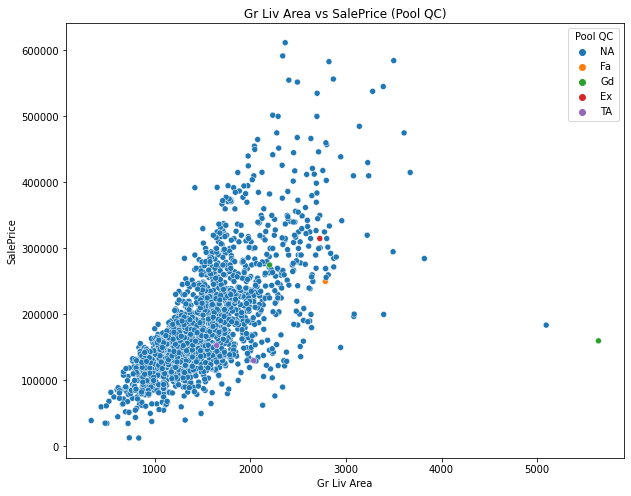

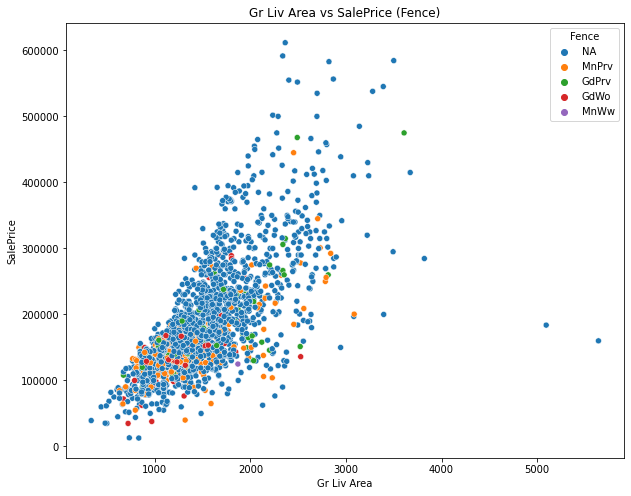

In [39]:
# Scatterplot of Gr Liv Area and SalePrice with ordinal variables set as hue to determine wheteher to put them on a numeric scale or not.
# If there isn't a clear relationship or visually hard to see any particular pattern, I chose to leave it as ordinal variable and convert to dummy variables later in the process.

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Lot Shape')
plt.title('Gr Liv Area vs SalePrice (Lot Shape)')

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Utilities')
plt.title('Gr Liv Area vs SalePrice (Utilities)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Land Slope')
plt.title('Gr Liv Area vs SalePrice (Land Slope)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Exter Qual')
plt.title('Gr Liv Area vs SalePrice (Exter Qual)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Exter Cond')
plt.title('Gr Liv Area vs SalePrice (Exter Cond)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Bsmt Qual')
plt.title('Gr Liv Area vs SalePrice (Bsmt Qual)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Bsmt Cond')
plt.title('Gr Liv Area vs SalePrice (Bsmt Cond)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Bsmt Exposure')
plt.title('Gr Liv Area vs SalePrice (Bsmt Exposure)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='BsmtFin Type 1')
plt.title('Gr Liv Area vs SalePrice (BsmtFin Type 1)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='BsmtFin Type 2')
plt.title('Gr Liv Area vs SalePrice (BsmtFin Type 2)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Heating QC')
plt.title('Gr Liv Area vs SalePrice (Heating QC)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Electrical')
plt.title('Gr Liv Area vs SalePrice (Electrical)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Kitchen Qual')
plt.title('Gr Liv Area vs SalePrice (Kitchen Qual)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Functional')
plt.title('Gr Liv Area vs SalePrice (Functional)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Fireplace Qu')
plt.title('Gr Liv Area vs SalePrice (Fireplace Qu)');


plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Garage Finish')
plt.title('Gr Liv Area vs SalePrice (Garage Finish)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Garage Qual')
plt.title('Gr Liv Area vs SalePrice (Garage Qual)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Garage Cond')
plt.title('Gr Liv Area vs SalePrice (Garage Cond)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Pool QC')
plt.title('Gr Liv Area vs SalePrice (Pool QC)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='Fence')
plt.title('Gr Liv Area vs SalePrice (Fence)');

In [40]:
# Dictionary to convert ordinal varibles into numeric variables (only if order is visually present)
# For instance, there is a clear distincion between EX, GD, TA, FA in Exter Qual whereas Pool QC, it doesn't tell much story other than that most houses don't have a pool.

numeric_scores = {
           'NA':0, 
           'Po':2, 
           'Fa':4, 
           'TA':6, 
           'Gd':8, 
           'Ex':10,
           'Gd':4,
           'Av':3,
           'Mn':2,
           'No':1,
           'GLQ':10,
           'ALQ':8,
           'BLQ':6,
           'Rec':4,
           'LwQ':2,
           'Unf':0,
           'Fin':3,
           'RFn':2,
           'Unf':1,
}


ames['Exter Qual'] = ames['Exter Qual'].map(numeric_scores)
ames['Bsmt Qual'] = ames['Bsmt Qual'].map(numeric_scores)
ames['Bsmt Exposure'] = ames['Bsmt Exposure'].map(numeric_scores)
ames['BsmtFin Type 1'] = ames['BsmtFin Type 1'].map(numeric_scores)
ames['Heating QC'] = ames['Heating QC'].map(numeric_scores)
ames['Kitchen Qual'] = ames['Kitchen Qual'].map(numeric_scores)
ames['Garage Finish'] = ames['Garage Finish'].map(numeric_scores)

In [41]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 86 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2051 non-null   object 
 1   MS Zoning        2051 non-null   object 
 2   Lot Frontage     2051 non-null   float64
 3   Lot Area         2051 non-null   int64  
 4   Street           2051 non-null   object 
 5   Alley            2051 non-null   object 
 6   Lot Shape        2051 non-null   object 
 7   Land Contour     2051 non-null   object 
 8   Utilities        2051 non-null   object 
 9   Lot Config       2051 non-null   object 
 10  Land Slope       2051 non-null   object 
 11  Neighborhood     2051 non-null   object 
 12  Condition 1      2051 non-null   object 
 13  Condition 2      2051 non-null   object 
 14  Bldg Type        2051 non-null   object 
 15  House Style      2051 non-null   object 
 16  Overall Qual     2051 non-null   int64  
 17  Overall Cond  

### EDA

In [42]:
ames.describe().T

count           mean           std      min       25%  \
Lot Frontage     2051.0      69.055200     21.306357     21.0      60.0   
Lot Area         2051.0   10065.208191   6742.488909   1300.0    7500.0   
Overall Qual     2051.0       6.112140      1.426271      1.0       5.0   
Overall Cond     2051.0       5.562165      1.104497      1.0       5.0   
Year Built       2051.0    1971.708922     30.177889   1872.0    1953.5   
Year Remod/Add   2051.0    1984.190151     21.036250   1950.0    1964.5   
Mas Vnr Area     2051.0      98.626524    174.324690      0.0       0.0   
Exter Qual       2051.0       5.452950      1.320423      4.0       4.0   
Bsmt Qual        2051.0       5.294978      1.927533      0.0       4.0   
Bsmt Exposure    2051.0       1.628961      1.079440      0.0       1.0   
BsmtFin Type 1   2051.0       5.476841      3.817140      0.0       1.0   
BsmtFin SF 1     2051.0     442.084837    461.195041      0.0       0.0   
BsmtFin SF 2     2051.0      47.935641    164.964052      0.0       0.0   
Bsmt Unf SF      2051.0     567.451487    445.022846      0.0     220.0   
Total Bsmt SF    2051.0    1057.471965    449.908003      0.0     793.0   
Heating QC       2051.0       7.694783      2.493008      2.0       6.0   
1st Flr SF       2051.0    1164.488055    396.446923    334.0     879.5   
2nd Flr SF       2051.0     329.329108    425.671046      0.0       0.0   
Low Qual Fin SF  2051.0       5.512921     51.068870      0.0       0.0   
Gr Liv Area      2051.0    1499.330083    500.447829    334.0    1129.0   
Bsmt Full Bath   2051.0       0.427109      0.522589      0.0       0.0   
Bsmt Half Bath   2051.0       0.063384      0.251590      0.0       0.0   
Full Bath        2051.0       1.577279      0.549279      0.0       1.0   
Half Bath        2051.0       0.371039      0.501043      0.0       0.0   
Bedroom AbvGr    2051.0       2.843491      0.826618      0.0       2.0   
Kitchen AbvGr    2051.0       1.042906      0.209790      0.0       1.0   
Kitchen Qual     2051.0       5.462701      1.598154      4.0       4.0   
TotRms AbvGrd    2051.0       6.435885      1.560225      2.0       5.0   
Fireplaces       2051.0       0.590931      0.638516      0.0       0.0   
Garage Yr Blt    2051.0    1868.725987    454.133654      0.0    1957.0   
Garage Finish    2051.0       1.723062      0.898969      0.0       1.0   
Garage Cars      2051.0       1.775719      0.765357      0.0       1.0   
Garage Area      2051.0     473.440761    216.135102      0.0     319.0   
Wood Deck SF     2051.0      93.833740    128.549416      0.0       0.0   
Open Porch SF    2051.0      47.556802     66.747241      0.0       0.0   
Enclosed Porch   2051.0      22.571916     59.845110      0.0       0.0   
3Ssn Porch       2051.0       2.591419     25.229615      0.0       0.0   
Screen Porch     2051.0      16.511458     57.374204      0.0       0.0   
Pool Area        2051.0       2.397855     37.782570      0.0       0.0   
Misc Val         2051.0      51.574354    573.393985      0.0       0.0   
Mo Sold          2051.0       6.219893      2.744736      1.0       4.0   
Yr Sold          2051.0    2007.775719      1.312014   2006.0    2007.0   
SalePrice        2051.0  181469.701609  79258.659352  12789.0  129825.0   
has_garage       2051.0       0.944417      0.229170      0.0       1.0   
has_pool         2051.0       0.004388      0.066113      0.0       0.0   
has_fireplace    2051.0       0.512433      0.499967      0.0       0.0   
has_porch        2051.0       0.555339      0.497049      0.0       0.0   
has_basement     2051.0       0.973184      0.161585      0.0       1.0   
Bsmt Bath        2051.0       0.458801      0.519272      0.0       0.0   
Total Bath       2051.0       1.762799      0.637775      0.0       1.0   

                         50%       75%       max  
Lot Frontage         69.0552      78.0     313.0  
Lot Area           9430.0000   11513.5  159000.0  
Overall Qual          6.0000       7.0 

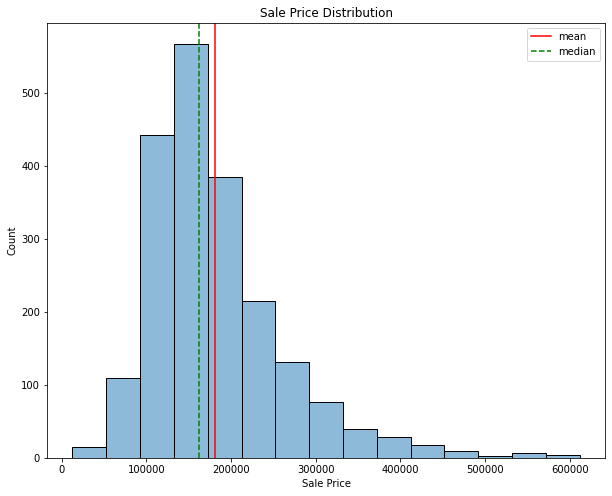

In [43]:
plt.figure(figsize=(10,8))

sns.histplot((ames['SalePrice']), bins=15, alpha=0.5)
plt.axvline(ames['SalePrice'].mean(), color='red')
plt.axvline(ames['SalePrice'].median(), color='green', linestyle = '--')
plt.legend(labels = ['mean','median']);
plt.xlabel(xlabel='Sale Price')
plt.title('Sale Price Distribution');

***Since the Sale Price is the target variable, I created a distribution chart to see any particular pattern or trend. Visually, I noticed that sale price is skewed to the right. To account for this behavior, I determined it would be appropriate to log transform the target variable.***

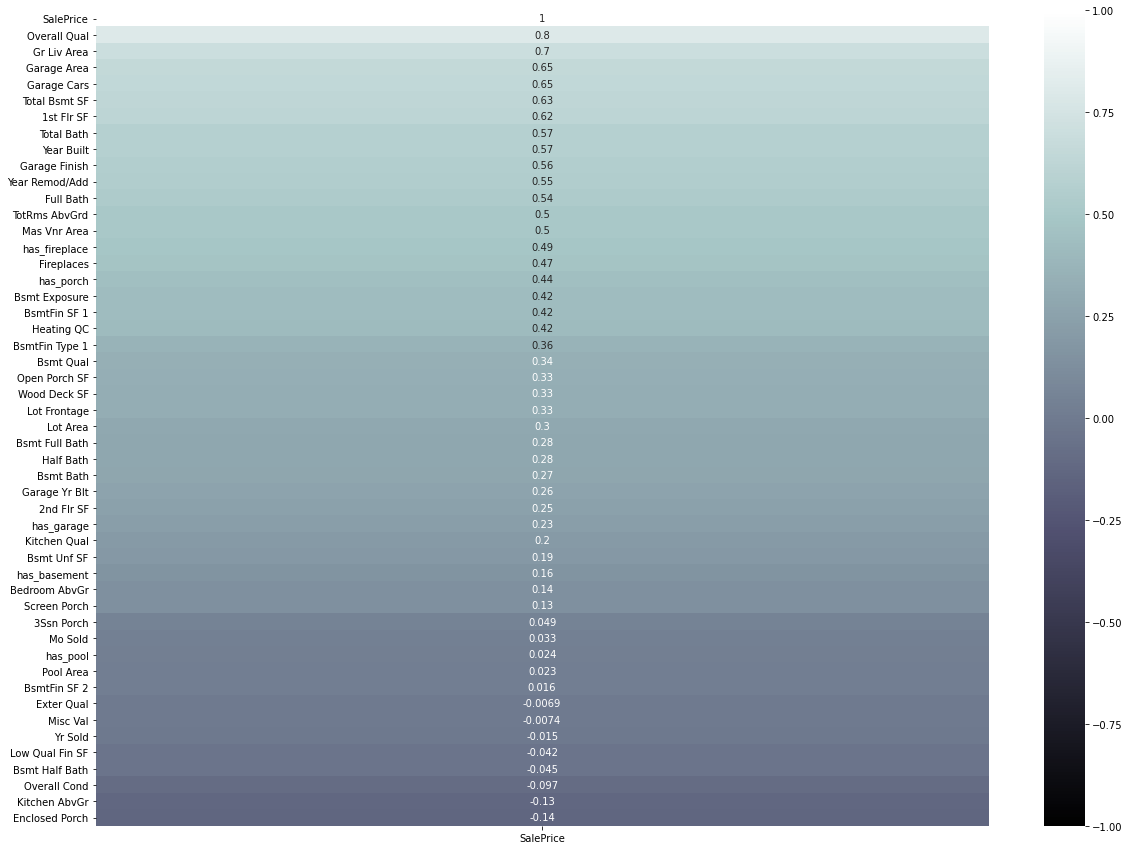

In [44]:
plt.figure(figsize=(20,15))
sns.heatmap(ames.corr()[['SalePrice']].sort_values('SalePrice',ascending=False),annot=True,cmap ='bone', vmin=-1, vmax=1);

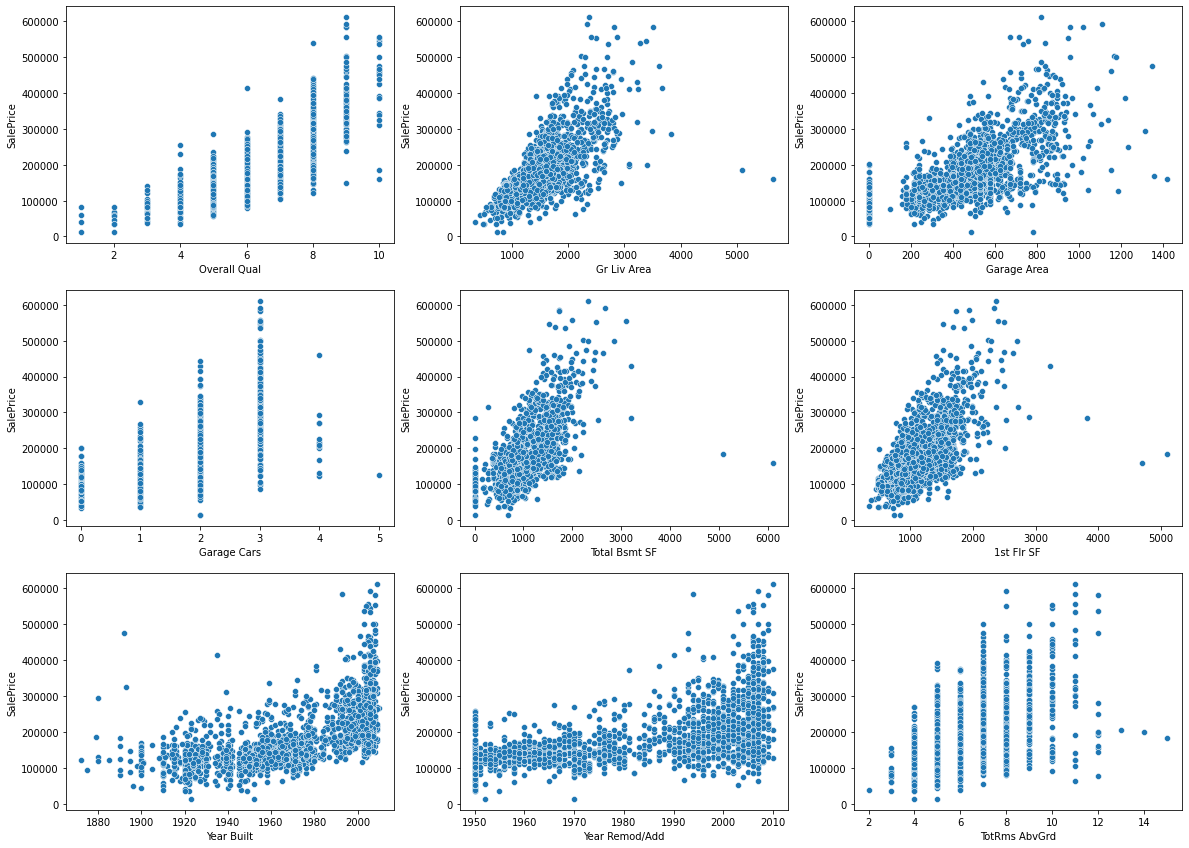

In [45]:
# Examining top features with high R2 to see visually examine linearity.

plt.figure(figsize=(20,20))

plt.subplot(4,3,1)
sns.scatterplot(data=ames, x='Overall Qual', y='SalePrice')

plt.subplot(4,3,2)
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice')

plt.subplot(4,3,3)
sns.scatterplot(data=ames, x='Garage Area', y='SalePrice')

plt.subplot(4,3,4)
sns.scatterplot(data=ames, x='Garage Cars', y='SalePrice')


plt.subplot(4,3,5)
sns.scatterplot(data=ames, x='Total Bsmt SF', y='SalePrice')

plt.subplot(4,3,6)
sns.scatterplot(data=ames, x='1st Flr SF', y='SalePrice')

plt.subplot(4,3,7)
sns.scatterplot(data=ames, x='Year Built', y='SalePrice')

plt.subplot(4,3,8)
sns.scatterplot(data=ames, x='Year Remod/Add', y='SalePrice')

plt.subplot(4,3,9)
sns.scatterplot(data=ames, x='TotRms AbvGrd', y='SalePrice');

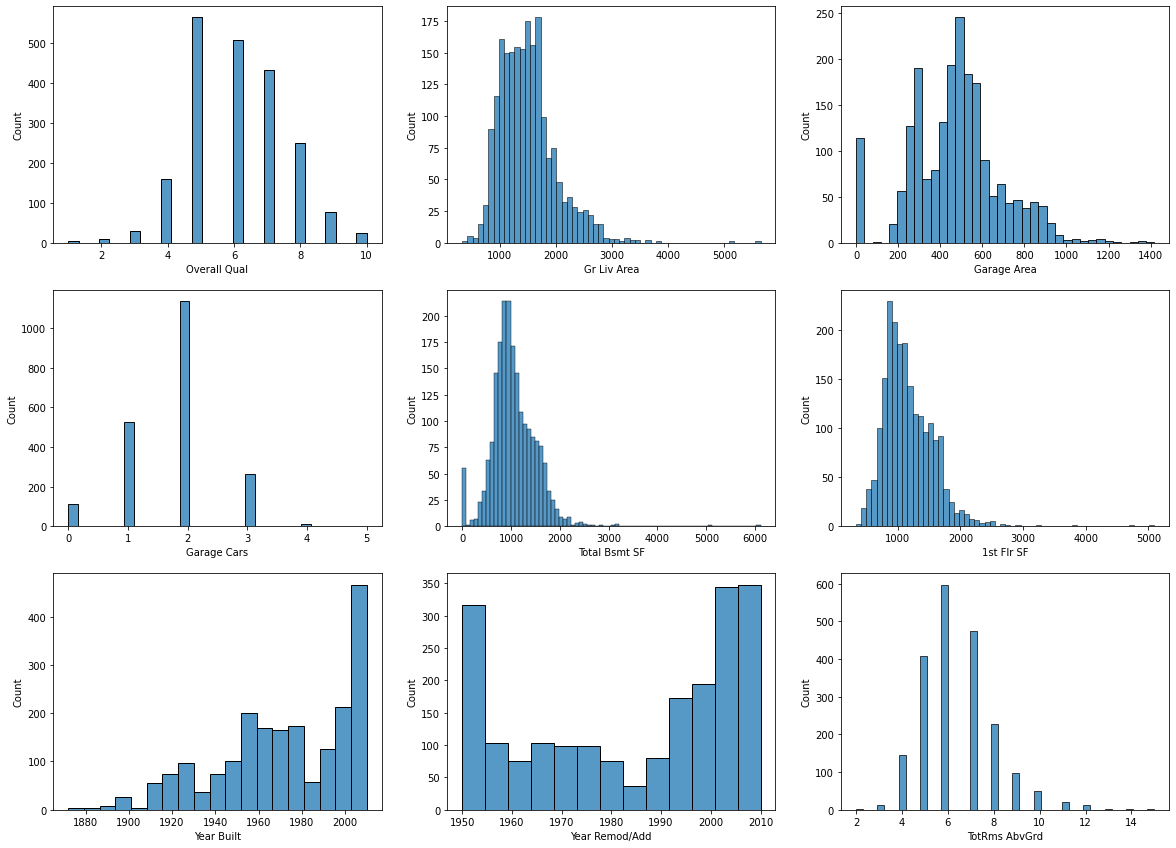

In [46]:
# Examining the distribution of features with high R2 score to see if we have any abnormal behavior

plt.figure(figsize=(20,20))

plt.subplot(4,3,1)
sns.histplot(ames['Overall Qual'])

plt.subplot(4,3,2)
sns.histplot(ames['Gr Liv Area'])

plt.subplot(4,3,3)
sns.histplot(ames['Garage Area'])

plt.subplot(4,3,4)
sns.histplot(ames['Garage Cars'])


plt.subplot(4,3,5)
sns.histplot(ames['Total Bsmt SF'])

plt.subplot(4,3,6)
sns.histplot(ames['1st Flr SF'])

plt.subplot(4,3,7)
sns.histplot(ames['Year Built'])

plt.subplot(4,3,8)
sns.histplot(ames['Year Remod/Add'])

plt.subplot(4,3,9)
sns.histplot(ames['TotRms AbvGrd']);

In [47]:
# Identified two outliers with very high Gr Liv Area but low price.

ames[ames['Gr Liv Area']>=4000]

MS SubClass MS Zoning  Lot Frontage  Lot Area Street     Alley Lot Shape  \
960           60        RL         313.0     63887   Pave  No Alley       IR3   
1885          20        RL         128.0     39290   Pave  No Alley       IR1   

     Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1  \
960           Bnk    AllPub     Corner        Gtl      Edwards       Feedr   
1885          Bnk    AllPub     Inside        Gtl      Edwards        Norm   

     Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
960         Norm      1Fam      2Story            10             5   
1885        Norm      1Fam      1Story            10             5   

      Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
960         2008            2008        Hip   ClyTile       Stucco   
1885        2008            2009        Hip   CompShg      CemntBd   

     Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual Exter Cond  \
960        Stucco        Stone         796.0          10         TA   
1885      CmentBd        Stone        1224.0          10         TA   

     Foundation  Bsmt Qual Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
960       PConc         10        TA              4              10   
1885      PConc         10        TA              4              10   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
960         5644.0            Unf           0.0        466.0         6110.0   
1885        4010.0            Unf           0.0       1085.0         5095.0   

     Heating  Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
960     GasA          10           Y      SBrkr        4692         950   
1885    GasA          10           Y      SBrkr        5095           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
960                 0         5642             2.0             0.0          2   
1885                0         5095             1.0             1.0          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  \
960           1              3              1            10             12   
1885          1              2              1            10             15   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
960         Typ           3           Gd      Attchd         2008.0   
1885        Typ           2           Gd      Attchd         2008.0   

      Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
960               3          2.0       1418.0          TA          TA   
1885              3          3.0       1154.0          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
960            Y           214            292               0           0   
1885           Y           546            484               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val  Mo Sold  \
960              0        480      Gd    NA           NA         0        1   
1885             0          0      NA    NA         Elev     17000       10   

      Yr Sold Sale Type  SalePrice  has_garage  has_pool  has_fireplace  \
960      2008       New     160000           1         1              1   
1885     2007       New     183850           1         0              1   

      has_porch  has_basement  Bsmt Bath  Total Bath  
960           1             1        2.0         2.5  
1885          1             1        1.5         2.5

In [48]:
# Dropping two outliers where we have high Gr Liv Area, low price.

ames.drop(index=[960,1885], axis=0, inplace=True) 

In [49]:
# Identified two outliers where the log of sale price is less than 10.

ames[np.log(ames['SalePrice'])<10]

MS SubClass MS Zoning  Lot Frontage  Lot Area Street     Alley Lot Shape  \
183           20   A (agr)          80.0     14584   Pave  No Alley       Reg   
1628          30        RM          68.0      9656   Pave  No Alley       Reg   

     Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1  \
183           Low    AllPub     Inside        Mod       IDOTRR        Norm   
1628          Lvl    AllPub     Inside        Gtl      OldTown        Norm   

     Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
183         Norm      1Fam      1Story             1             5   
1628        Norm      1Fam      1Story             2             2   

      Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
183         1952            1952      Gable   CompShg      AsbShng   
1628        1923            1970      Gable   CompShg      AsbShng   

     Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual Exter Cond  \
183       VinylSd         None           0.0           4         Po   
1628      AsbShng         None           0.0           6         Fa   

     Foundation  Bsmt Qual Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
183        Slab          0        NA              0               0   
1628     BrkTil          4        Fa              1               1   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
183            0.0             NA           0.0          0.0            0.0   
1628           0.0            Unf           0.0        678.0          678.0   

     Heating  Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
183     Wall           2           N      FuseA         733           0   
1628    GasA           6           N      SBrkr         832           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
183                 0          733             0.0             0.0          1   
1628                0          832             0.0             0.0          1   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  \
183           0              2              1             4              4   
1628          0              2              1             6              5   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
183         Sal           0           NA      Attchd         1952.0   
1628        Typ           1           Gd      Detchd         1928.0   

      Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
183               1          2.0        487.0          Fa          Po   
1628              1          2.0        780.0          Fa          Fa   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
183            N             0              0               0           0   
1628           N             0              0               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val  Mo Sold  \
183              0          0      NA    NA           NA         0        2   
1628             0          0      NA    NA           NA         0        6   

      Yr Sold Sale Type  SalePrice  has_garage  has_pool  has_fireplace  \
183      2008       WD       13100           1         0              0   
1628     2010       WD       12789           1         0              1   

      has_porch  has_basement  Bsmt Bath  Total Bath  
183           0             0        0.0         1.0  
1628          0             1        0.0         1.0

In [50]:
# Dropping two outliers where log of sale price is less than 10 as it is an outlier

ames.drop(index=[183,1628], axis=0, inplace=True) 

In [51]:
ames.shape

(2047, 86)

In [52]:
# Resetting the index

ames.reset_index(drop=True)

MS SubClass MS Zoning  Lot Frontage  Lot Area Street     Alley Lot Shape  \
0             60        RL       69.0552     13517   Pave  No Alley       IR1   
1             60        RL       43.0000     11492   Pave  No Alley       IR1   
2             20        RL       68.0000      7922   Pave  No Alley       Reg   
3             60        RL       73.0000      9802   Pave  No Alley       Reg   
4             50        RL       82.0000     14235   Pave  No Alley       IR1   
...          ...       ...           ...       ...    ...       ...       ...   
2042          20        RL       79.0000     11449   Pave  No Alley       IR1   
2043          30        RL       69.0552     12342   Pave  No Alley       IR1   
2044          50        RL       57.0000      7558   Pave  No Alley       Reg   
2045          20        RL       80.0000     10400   Pave  No Alley       Reg   
2046          60        RL       60.0000      7500   Pave  No Alley       Reg   

     Land Contour Utilities Lot Config Land Slope Neighborhood Condition 1  \
0             Lvl    AllPub    CulDSac        Gtl       Sawyer        RRAe   
1             Lvl    AllPub    CulDSac        Gtl      SawyerW        Norm   
2             Lvl    AllPub     Inside        Gtl        NAmes        Norm   
3             Lvl    AllPub     Inside        Gtl       Timber        Norm   
4             Lvl    AllPub     Inside        Gtl      SawyerW        Norm   
...           ...       ...        ...        ...          ...         ...   
2042          HLS    AllPub     Inside        Gtl       Timber        Norm   
2043          Lvl    AllPub     Inside        Gtl      Edwards        Norm   
2044          Bnk    AllPub     Inside        Gtl      Crawfor        Norm   
2045          Lvl    AllPub     Corner        Gtl        NAmes        Norm   
2046          Lvl    AllPub     Inside        Gtl      Gilbert        Norm   

     Condition 2 Bldg Type House Style  Overall Qual  Overall Cond  \
0           Norm      1Fam      2Story             6             8   
1           Norm      1Fam      2Story             7             5   
2           Norm      1Fam      1Story             5             7   
3           Norm      1Fam      2Story             5             5   
4           Norm      1Fam      1.5Fin             6             8   
...          ...       ...         ...           ...           ...   
2042        Norm      1Fam      1Story             8             5   
2043        Norm      1Fam      1Story             4             5   
2044        Norm      1Fam      1.5Fin             6             6   
2045        Norm      1Fam      1Story             4             5   
2046        Norm      1Fam      2Story             7             5   

      Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
0           1976            2005      Gable   CompShg      HdBoard   
1           1996            1997      Gable   CompShg      VinylSd   
2           1953            2007      Gable   CompShg      VinylSd   
3           2006            2007      Gable   CompShg      VinylSd   
4           1900            1993      Gable   CompShg      Wd Sdng   
...          ...             ...        ...       ...          ...   
2042        2007            2007      Gable   CompShg      VinylSd   
2043        1940            1950      Gable   CompShg      VinylSd   
2044        1928            1950      Gable   CompShg      BrkFace   
2045        1956            1956      Gable   CompShg      Plywood   
2046        1999            1999      Gable   CompShg      VinylSd   

     Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual Exter Cond  \
0         Plywood      BrkFace         289.0           4         TA   
1         VinylSd      BrkFace         132.0           4         TA   
2         VinylSd         None           0.0           6         Gd   
3         VinylSd         None           0.0           6         TA   
4         Plywood         None           0.0           6  

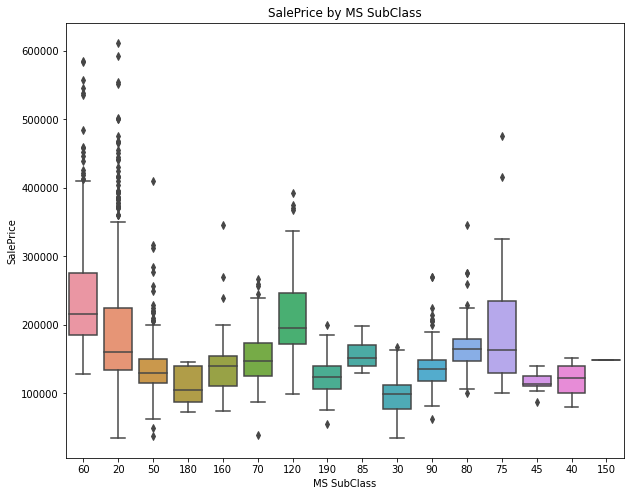

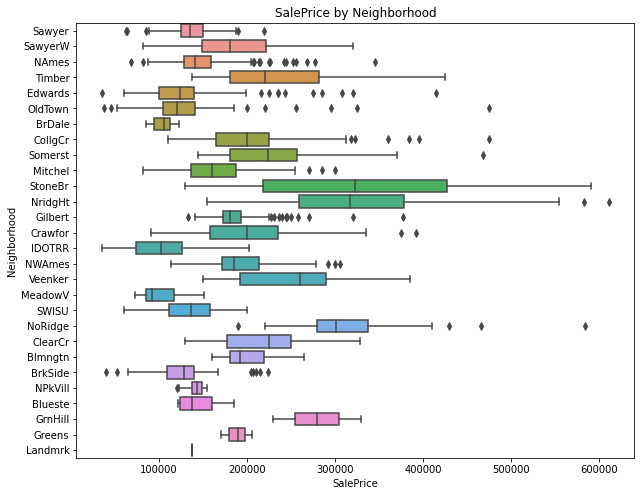

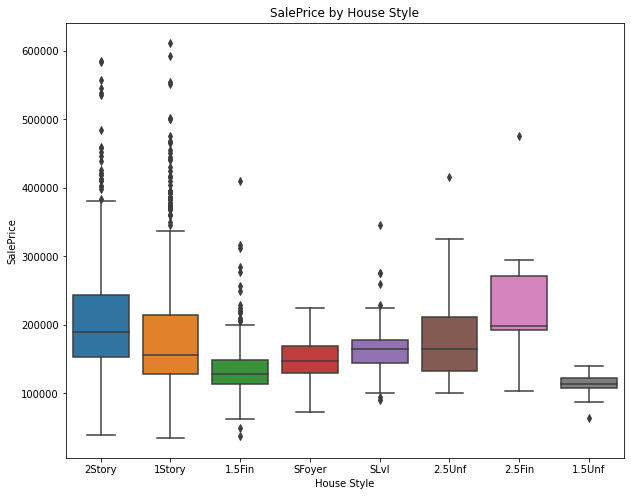

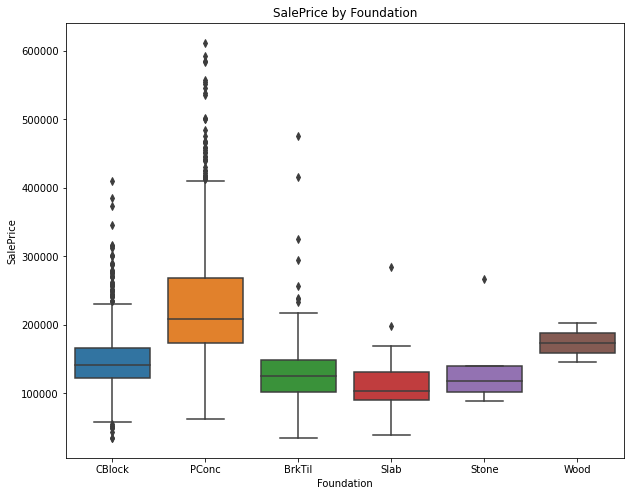

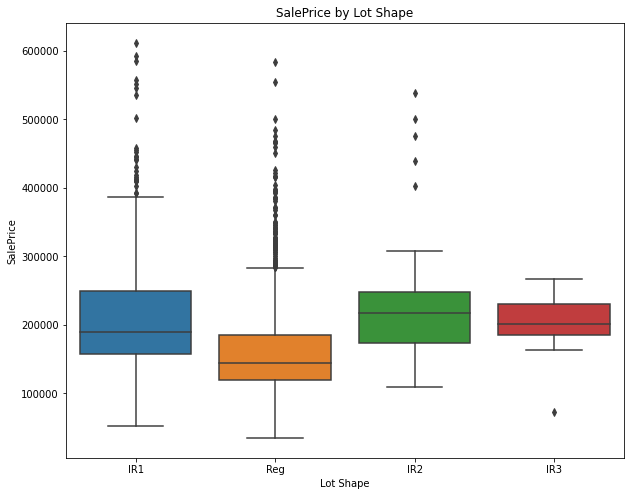

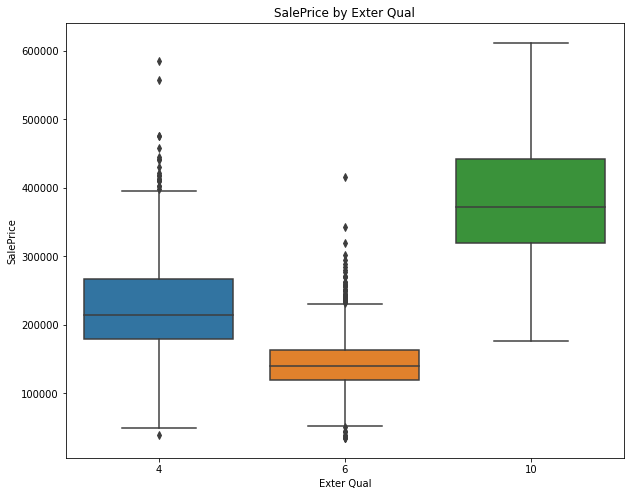

In [53]:
# Checking out exterior features

plt.figure(figsize=(10,8))
sns.boxplot(data=ames, x='MS SubClass', y='SalePrice')
plt.title('SalePrice by MS SubClass');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, y='Neighborhood', x='SalePrice')
plt.title('SalePrice by Neighborhood');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='House Style', y='SalePrice')
plt.title('SalePrice by House Style');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Foundation', y='SalePrice')
plt.title('SalePrice by Foundation');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Lot Shape', y='SalePrice')
plt.title('SalePrice by Lot Shape');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Exter Qual', y='SalePrice')
plt.title('SalePrice by Exter Qual');

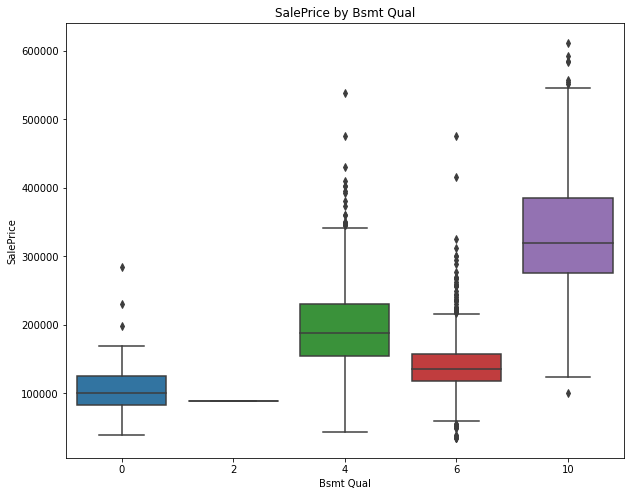

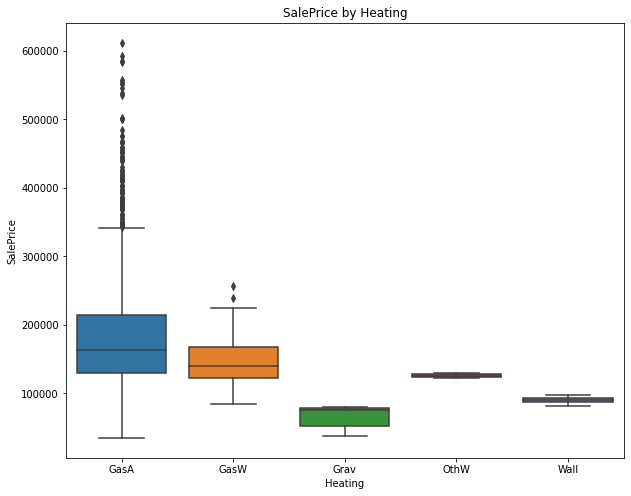

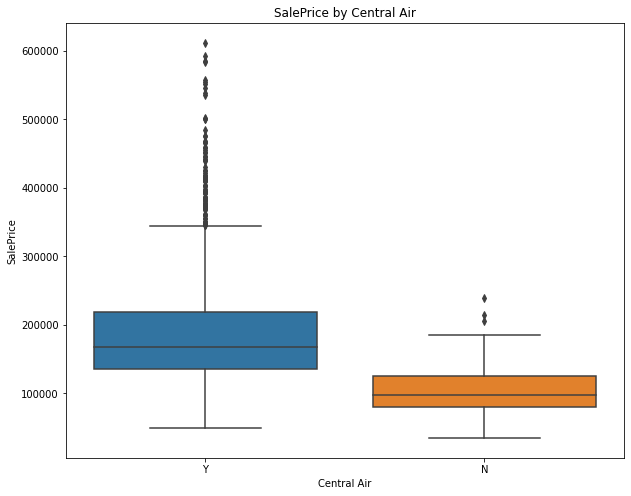

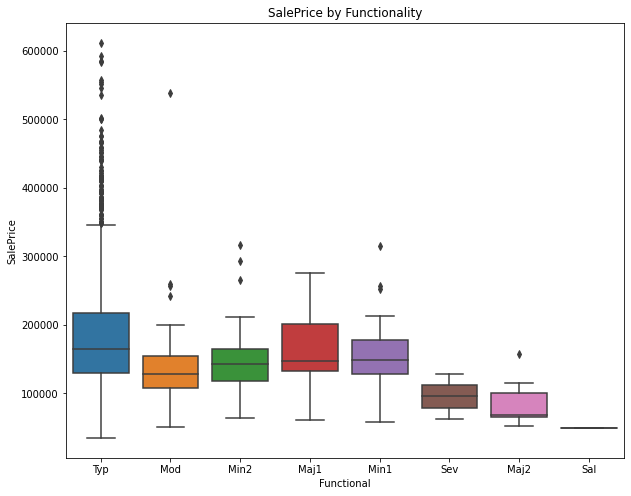

In [54]:
# Checking out inteterior features

plt.figure(figsize=(10,8))
sns.boxplot(data=ames, x='Bsmt Qual', y='SalePrice')
plt.title('SalePrice by Bsmt Qual');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Heating', y='SalePrice')
plt.title('SalePrice by Heating');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Central Air', y='SalePrice')
plt.title('SalePrice by Central Air');

plt.figure(figsize=(10,8))
sns.boxplot(data= ames, x='Functional', y='SalePrice')
plt.title('SalePrice by Functionality');

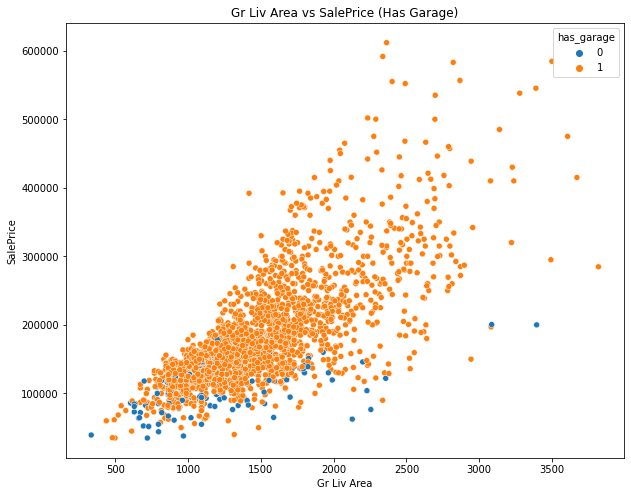

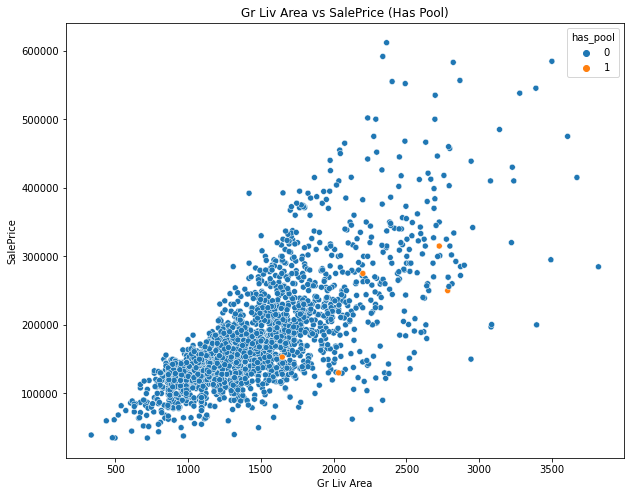

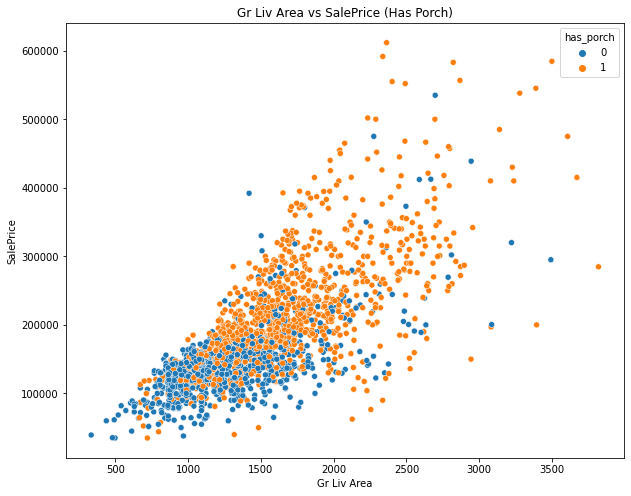

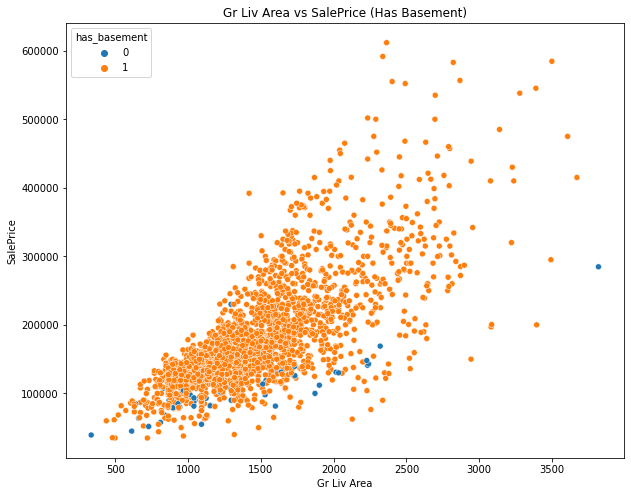

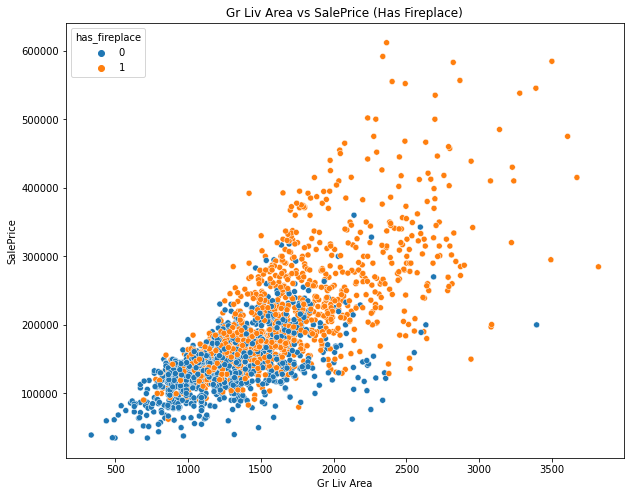

In [55]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='has_garage')
plt.title('Gr Liv Area vs SalePrice (Has Garage)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='has_pool')
plt.title('Gr Liv Area vs SalePrice (Has Pool)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='has_porch')
plt.title('Gr Liv Area vs SalePrice (Has Porch)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='has_basement')
plt.title('Gr Liv Area vs SalePrice (Has Basement)');

plt.figure(figsize=(10,8))
sns.scatterplot(data=ames, x='Gr Liv Area', y='SalePrice', hue='has_fireplace')
plt.title('Gr Liv Area vs SalePrice (Has Fireplace)');




### Observations

Examining the dataset more closely through visualization revealed some key information to help with this analysis.

* Sale Price is skewed to the right. To account for this, log transformation of the target variable seems appropriate.

* Linear regression appears to be an appropriate model to fit. Top features with high R2 score clearly reveal linear relationship to the target variable. Other assumptions such as independence, normality of error, and equal variance should be considered once the model is fit.

* Certain exterior/interior features seem to indicate buyers are willing to pay premium for those features. For example, Central Air seems to be an important feature that homebuyers consider to be important where as Lot Shape isn't as important in the home buying decision.

* Not all ordinal variables were converted to numeric variables. While some ordinal variables contained within themselves important information about the order of things, but some did not offer any predictive information.

* Generally speaking, there seems to be a strong relationship between sale price and the size/area of each home. This jives with common sense since one of the metrics that people often run into in real estate is $/sq ft.

* Having a garage, porch, and fireplace seem to be important features for homebuyers as they are willilng to pay premium for those features. Having a pool doesn't seem that relevant since it looks like most homes in Ames do not have a pool. 

### Setting Up for Linear Regression

* To set up for linear regression, I chose to focus on all the features as my potential variables and log transform the target price, which in this case is Sale Price. I applied PolynomialFeatures to create all possible interative terms in the degree of 2. While I debated whether I should narrow down my features early at this stage based on R2 threshold of >0.50, I felt that stripping out features too early on may result in losing out on potential predictive power for features with low R2 score. The assumption that low features cannot provide predictive power when combined with other terms was a too big of a leap. The downside to this approach was the fast expansion of my features. To reduce my number of features down to something reasonble to work with, I ran the OLS summary test and stripped out statistically insignificant features based on p-value < 0.05 threshold.

In [56]:
# Setting up to perform a MLR.

xvars = ames._get_numeric_data().columns.drop('SalePrice')
X = ames[xvars]
y = np.log(ames['SalePrice']) # Taking the log of the sale price to account for positive skewdness as explored above.

In [57]:
# Applying feature engineering to my selected features
# Using degree of 2

poly = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly.fit_transform(X)

poly.get_feature_names(xvars)[0:15] # Shortening the list as there are a a lot of features

['Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'Exter Qual',
 'Bsmt Qual',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF']

In [58]:

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)
    
    # Instantiate linear regression
    lr = LinearRegression()
    
    # Fit the train data
    lr.fit(X_train, y_train)
    
    # Calculate R2, MSE, and RMSE for the train data
    cvs_train_r2 = cross_val_score(lr, X=X_train, y=y_train)
    cvs_train_r2_mean = cross_val_score(lr, X=X_train, y=y_train).mean()
    model_train_r2 = lr.score(X_train, y_train)
    mse_train = metrics.mean_squared_error(y_train, lr.predict(X_train))
    rmse_train = metrics.mean_squared_error(y_train, lr.predict(X_train), squared=False)
    mse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train)))
    rmse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train)), squared=False)
    
    # Calculate R2, MSE, and RMSE for the test data
    cvs_test_r2 = cross_val_score(lr, X=X_test, y=y_test)
    cvs_test_r2_mean = cross_val_score(lr, X=X_test, y=y_test).mean()
    model_test_r2 = lr.score(X_test, y_test)
    mse_test = metrics.mean_squared_error(y_test, lr.predict(X_test))
    rmse_test = metrics.mean_squared_error(y_test, lr.predict(X_test), squared=False)
    mse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)))
    rmse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)), squared=False)
    
    # Create a dataframe to consolidate train/test metrics
    Score_Summary_OLS = pd.DataFrame({'Metrics':['CVS_Mean','Model R2','MSE','RMSE','MSE_exp','RMSE_exp'],
                               'Train':[cvs_train_r2_mean, model_train_r2, mse_train, rmse_train, mse_train_exp, rmse_train_exp],
                               'Test':[cvs_test_r2_mean, model_test_r2, mse_test, rmse_test, mse_test_exp, rmse_test_exp]})
    
    Score_Summary_OLS


Metrics         Train          Test
0  CVS_Mean -8.902958e+07 -6.750630e+02
1  Model R2  9.803223e-01 -5.436307e+02
2       MSE  3.154945e-03  9.203926e+01
3      RMSE  5.616890e-02  9.593709e+00
4   MSE_exp  9.953998e+07  2.820459e+31
5  RMSE_exp  9.976973e+03  5.310800e+15

In [59]:
# Baseline Metrics Summary

y_bar = y.mean()

MSE_baseline = np.mean((y - y_bar) ** 2)
RMSE_baseline = np.sqrt(np.mean((y - y_bar) ** 2))
MSE_exp_baseline = np.mean((np.exp(y) - np.exp(y_bar)) ** 2)
RMSE_exp_baseline = np.sqrt(np.mean((np.exp(y) - np.exp(y_bar)) ** 2))


# Consolidate metrics and save as dataframe
Baseline_Summary = pd.DataFrame({'Metrics':['MSE', 'RMSE','MSE_exp','RMSE_exp'],
                               'Baseline':[MSE_baseline, RMSE_baseline, MSE_exp_baseline, RMSE_exp_baseline]})


Baseline_Summary.set_index('Metrics')


Baseline
Metrics               
MSE       1.630341e-01
RMSE      4.037748e-01
MSE_exp   6.472137e+09
RMSE_exp  8.044959e+04

For the purpose of this analysis, I decided to focus on R2, MSE, and RMSE (in both log and exponentiated scale) as my model performance metrics. Since the Kaggle competition is ranked based on RMSE, I decided to pay closer attention to RMSE. RMSE is also easier to interpret since the error is interpretable in the unit of the data.

I also created a baseline summary to compare my model performance against the baseline. While the baseline itself doesn't provide much information, it can serve as a good point of reference to see how much more predictive power my model can have compared to the baseline.

At this particular point in the process, the model is in serious need of fine-tuning and should not be used for any interpretation or prediction. With unseen test data, model at this junction performs worse than the baseline. The model is extremely overfit and additional steps are required to bring down the features in order to increase bias and lower variance.

Before doing so, there is one additional step which is to layer in categorical and ordinal data into the equation and factor them into the model as well as dummy variables. 

In [60]:
# Identify categorical features

numeric_columns = ames._get_numeric_data().columns

none_numeric_columns = [i for i in ames.columns if i not in numeric_columns]

In [61]:
none_numeric_columns

['MS SubClass',
 'MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Cond',
 'Foundation',
 'Bsmt Cond',
 'BsmtFin Type 2',
 'Heating',
 'Central Air',
 'Electrical',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type']

In [62]:
# Setting up to create dummy variables

X_dummy = ames[none_numeric_columns]

In [63]:
# Create dummy variables

X_dummy = pd.get_dummies(X_dummy, columns=none_numeric_columns, drop_first=True)

In [64]:
# Reset the index. This is important since I need to merge and it will be based on index.

X_dummy.reset_index(drop=True, inplace=True)

In [65]:
# Create a dataframe to store my feature engineered X

X_poly_set = pd.DataFrame(X_poly, columns = poly.get_feature_names(xvars))

In [66]:
# Reset the index (for merging purpose)

X_poly_set.reset_index(drop=True, inplace=True)

In [67]:
# Merge

X_1 = pd.concat([X_dummy, X_poly_set],axis=1)

In [68]:
X_1.shape

(2047, 1484)

To systematically reduce the number of features in my model, I decided to run the OLS summary test using the statsmodel module to be able to narrow down my features to ones with statistical significance based on p-value < 0.05 threshold.

In [69]:
# Resetting the index for the target variable. This is neessary in orer to align the index between my transformed X_1 and the target variable.

y.reset_index(drop=True, inplace=True)

In [70]:
# Setting up to run the OLS summary

X_1_OLS = X_1

X_1_OLS = sm.add_constant(X_1_OLS)

OLS = sm.OLS(y, X_1_OLS).fit()

OLS.summary()

/Users/young_park/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     44.23
Date:                Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:47:31   Log-Likelihood:                 3067.7
No. Observations:                2047   AIC:                            -3869.
Df Residuals:                     914   BIC:                             2503.
Df Model:                        1132                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.3337      1.645      2.634      0.009       1.105       7.562
MS SubClass_150                   -2.4427      0.930     -2.628      0.009      -4.267      -0.618
MS SubClass_160                   -0.0476      0.078     -0.611      0.542      -0.201       0.105
MS SubClass_180                   -0.1063      0.091     -1.170      0.242      -0.284       0.072
MS SubClass_190                    0.1138      0.124      0.918      0.359      -0.130       0.357
MS SubClass_20                     0.0315      0.066      0.474      0.636      -0.099       0.162
MS SubClass_30                     0.0127      0.071      0.179      0.858      -0.126       0.151
MS SubClass_40                    -0.0124      0.105     -0.119      0.905      -0.218       0.193
MS SubClass_45                     0.0017      0.133      0.013      0.990      -0.259       0.262
MS SubClass_50                     0.0106      0.085      0.125      0.901      -0.156       0.177
MS SubClass_60                     0.0385      0.098      0.391      0.696      -0.155       0.232
MS SubClass_70                     0.0347      0.098      0.355      0.723      -0.157       0.226
MS SubClass_75                    -0.0375      0.131     -0.286      0.775      -0.295       0.220
MS SubClass_80                    -0.1077      0.097     -1.105      0.269      -0.299       0.084
MS SubClass_85                    -0.0233      0.094     -0.248      0.804      -0.208       0.161
MS SubClass_90                    -0.0027      0.049     -0.055      0.956      -0.099       0.093
MS Zoning_C (all)                 -0.6194      1.095     -0.566      0.572      -2.768       1.529
MS Zoning_FV                      -0.2095      1.096     -0.191      0.848      -2.360       1.941
MS Zoning_I (all)                  0.0438      0.514      0.085      0.932      -0.965       1.053
MS Zoning_RH                      -0.2300      1.095     -0.210      0.834      -2.380       1.920
MS Zoning_RL                      -0.2352      1.095     -0.215      0.830      -2.385       1.914
MS Zoning_RM                      -0.2815      1.098     -0.256      0.798      -2.436       1.873
Street_Pave                        0.0344      0.067      0.512      0.609      -0.097       0.166
Alley_No Alley                    -0.0350      0.020     -1.719      0.086      -0.075       0.005
Alley_Pave                        -0.0095      0.031     -0.304      0.762      -0.071       0.052
Lot Shape_IR2                      0.0121      0.020      0.612      0.541      -0.027       0.051
Lot Shape_IR3                     -0.0519      0.048     -1.072      0.284      -0.147       0.043
Lot Shape_Reg                      0.0013      0.007      0.188      0.851      -0.012       0.015
Land Contour_H

**Side note: notice that R2 and adjusted R2 are both very high, 0.98 and 0.96 respectively. However, these scores are misleading at this point since my model tested so poorly with unseen test data.**

In [72]:
# Turning OLS summary above into a dataframe so I can eliminate statistically insignicicant features based on p-value <0.05 threshold.
# I searched and found a solution on stackoverflow in the link below that enables turning OLS summary into a dataframe. 
# All credit for this code goes to person that posted the solution.
# https://stackoverflow.com/questions/59704703/can-i-extract-or-construct-as-a-pandas-dataframe-the-table-with-coefficient-valu


data = {'coef': OLS.params,
        'std err': OLS.bse,
        't': OLS.tvalues,
        'P>|t|': OLS.pvalues,
        '[0.025': OLS.conf_int()[0],
        '0.975]': OLS.conf_int()[1]}

X1_ols_summary = pd.DataFrame(data).round(3)

In [73]:
# Narrowing down features with p-value <0.05 and dropping const that was added to run the OLS summary.

xvars2 = list(X1_ols_summary[X1_ols_summary['P>|t|']<.05].T.columns)

# In addition, I am also dropping certain specific features that were missing from the Kaggle competition test data.

xvars2.remove('const')
xvars2.remove('Garage Qual_NA')
xvars2.remove('Exterior 1st_Stone')
xvars2.remove('Misc Feature_TenC')
xvars2.remove('Neighborhood_GrnHill')
xvars2.remove('Garage Cond_NA')
xvars2.remove('Electrical_Mix')
xvars2.remove('Pool QC_NA')
xvars2.remove('MS SubClass_150')
xvars2.remove('Pool QC_Gd')
xvars2.remove('Pool QC_Fa')
xvars2.remove('Functional_Sev')

In [74]:
# Setting X_2 as matrix with features that have statistical significance

X_2 = X_1[xvars2] 

In [75]:
X_2.shape

(2047, 384)

### Setting up process evaluation

Up until this junction, I went through a series of systematic feature selection and feature engineering process to properly set up my X to be comptabible for linear regression models. In some sense, I intentially "overfit" my model because I wanted to make sure I capture potential predictive power/synergies between features with high R2 scores and low R2 scores. I also converted categorical and ordinal variables into dummy variables to account for their effect as well.

In the steps below, I explore three linear regression models (Ridge, Lasso, and ElasticNet) and compare the metrics to see which model performs best and test the fundamental assumptions required for linear regression (Linearity, Indepdnence, Normality of Error, Equal Variance).

### Ridge

Metrics         Train          Test
0     Alpha  1.394083e+02  1.394083e+02
1        R2  9.325862e-01  9.032306e-01
2       MSE  1.080855e-02  1.635344e-02
3      RMSE  1.039642e-01  1.278806e-01
4   MSE_exp  3.439266e+08  4.928301e+08
5  RMSE_exp  1.854526e+04  2.219978e+04

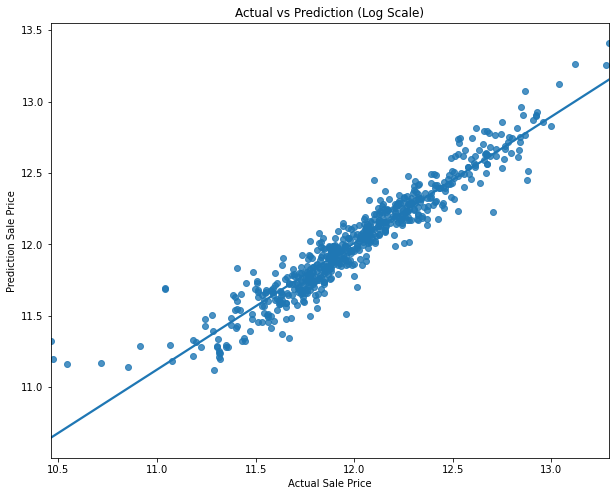

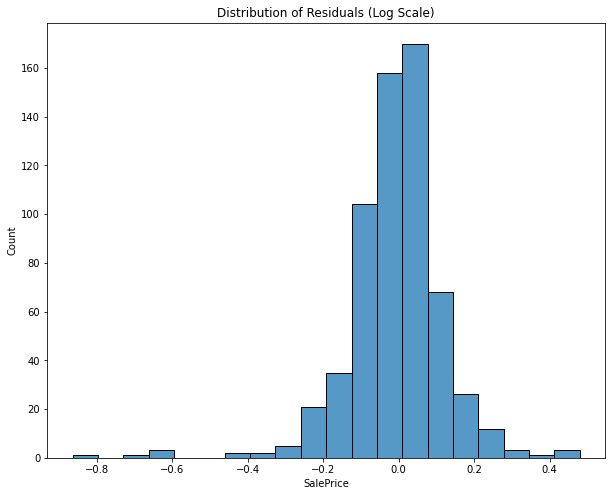

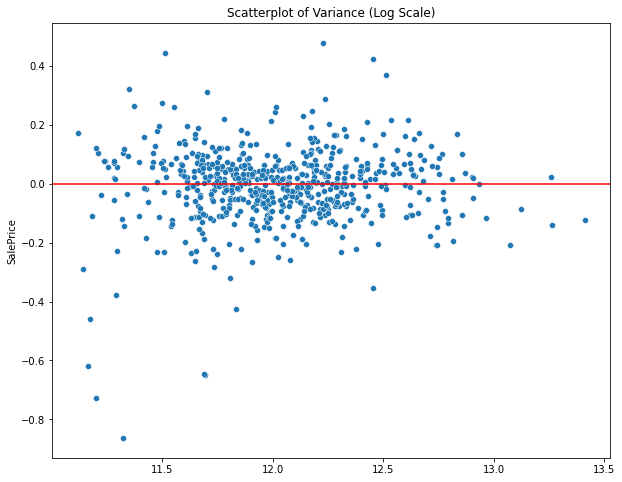

In [76]:

    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=0.3, random_state=42)
    
    # scaling my features
    ss = StandardScaler()
    Z_train = ss.fit_transform(X_train)
    Z_test = ss.transform(X_test)
    
    # finding the most optimal alpha via brute force (Lesson on regularization with Adi)
    r_alphas = np.logspace(0,10,500)
    ridge_cv = RidgeCV(alphas = r_alphas, scoring='r2', cv=5)
    
    # Fitting scaled train data
    ridge_cv.fit(Z_train, y_train)
    
    # Calculating metrics for the scaled train data
    ridge_alpha = ridge_cv.alpha_
    ridge_train_score = ridge_cv.score(Z_train, y_train)
    mse_train = metrics.mean_squared_error(y_train, ridge_cv.predict(Z_train))
    rmse_train = metrics.mean_squared_error(y_train, ridge_cv.predict(Z_train), squared=False)
    mse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(ridge_cv.predict(Z_train)))
    rmse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(ridge_cv.predict(Z_train)), squared=False)
       
    ridge_test_score = ridge_cv.score(Z_test, y_test)
    mse_test = metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test))
    rmse_test = metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test), squared=False)
    mse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(ridge_cv.predict(Z_test)))
    rmse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(ridge_cv.predict(Z_test)), squared=False)
    
    
    
    Score_Summary_Ridge = pd.DataFrame({'Metrics':['Alpha','R2','MSE','RMSE', 'MSE_exp','RMSE_exp'],
                                 'Train':[ridge_alpha, ridge_train_score, mse_train, rmse_train, mse_train_exp, rmse_train_exp],
                                 'Test':[ridge_alpha, ridge_test_score, mse_test, rmse_test, mse_test_exp, rmse_test_exp]})
    
    plt.figure(figsize=(10,8))
    sns.regplot(x=y_test, y=ridge_cv.predict(Z_test),ci=False)
    plt.title('Actual vs Prediction (Log Scale)')
    plt.xlabel(xlabel='Actual Sale Price')
    plt.ylabel(ylabel='Prediction Sale Price')
    

    resids_base = y_test - ridge_cv.predict(Z_test)
    plt.figure(figsize=(10,8))
    sns.histplot(resids_base, bins=20)
    plt.title('Distribution of Residuals (Log Scale)')

    plt.figure(figsize=(10,8))
    sns.scatterplot(x=ridge_cv.predict(Z_test), y=resids_base)
    plt.axhline(0, color='red')
    plt.title('Scatterplot of Variance (Log Scale)');
    
    
    Score_Summary_Ridge
    

### Lasso

Metrics         Train          Test
0     Alpha  2.459130e-03  2.459130e-03
1        R2  9.257869e-01  9.033463e-01
2       MSE  1.189869e-02  1.633388e-02
3      RMSE  1.090811e-01  1.278041e-01
4   MSE_exp  3.926733e+08  4.727594e+08
5  RMSE_exp  1.981599e+04  2.174303e+04

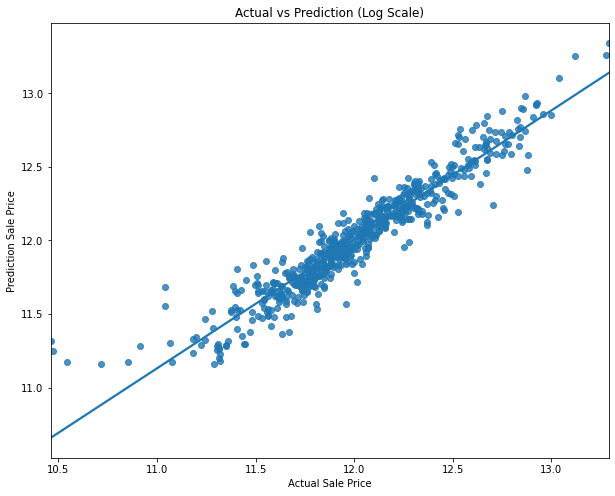

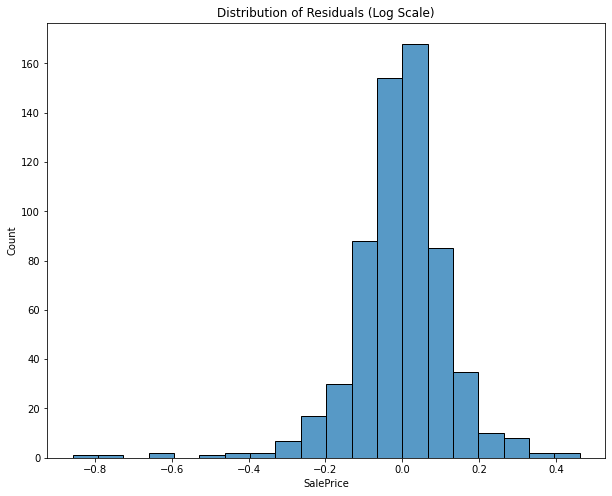

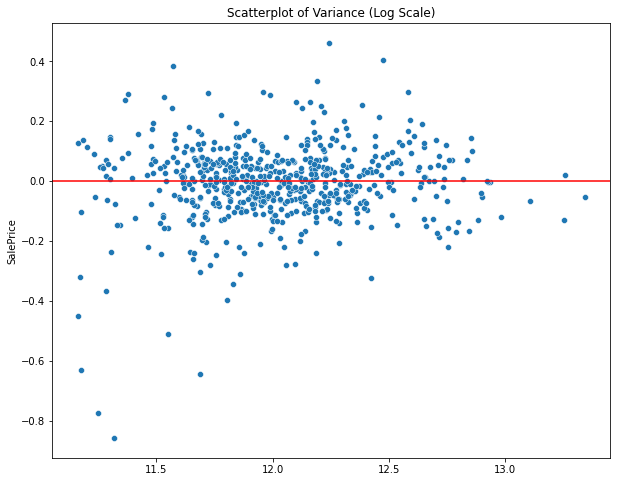

In [77]:

    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=0.3, random_state=42)
    
    # scaling my features
    ss = StandardScaler()
    Z_train = ss.fit_transform(X_train)
    Z_test = ss.transform(X_test)
    
    lasso_alphas = np.logspace(-3,10,500)
    
    lasso_cv = LassoCV(alphas = lasso_alphas, cv=5)
    
    lasso_cv.fit(Z_train, y_train)
    
    # scoring metrics for train data
    lasso_alpha = lasso_cv.alpha_
    lasso_train_score = lasso_cv.score(Z_train, y_train)
    mse_train = metrics.mean_squared_error(y_train, lasso_cv.predict(Z_train))
    rmse_train = metrics.mean_squared_error(y_train, lasso_cv.predict(Z_train), squared=False)
    mse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(lasso_cv.predict(Z_train)))
    rmse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(lasso_cv.predict(Z_train)), squared=False)
    
    # scoring metrics for test data
    lasso_test_score = lasso_cv.score(Z_test, y_test)
    mse_test = metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test))
    rmse_test = metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test), squared=False)
    mse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(lasso_cv.predict(Z_test)))
    rmse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(lasso_cv.predict(Z_test)), squared=False)
    
    # consolidating and creating a dataframe summary of metrics
    Score_Summary_Lasso = pd.DataFrame({'Metrics':['Alpha','R2','MSE','RMSE', 'MSE_exp','RMSE_exp'],
                                 'Train':[lasso_alpha, lasso_train_score, mse_train, rmse_train, mse_train_exp, rmse_train_exp],
                                 'Test':[lasso_alpha, lasso_test_score, mse_test, rmse_test, mse_test_exp, rmse_test_exp]})
    # visualizations
    plt.figure(figsize=(10,8))
    sns.regplot(x=y_test, y=lasso_cv.predict(Z_test),ci=False)
    plt.title('Actual vs Prediction (Log Scale)')
    plt.xlabel(xlabel='Actual Sale Price')
    plt.ylabel(ylabel='Prediction Sale Price')

    resids_base = y_test - lasso_cv.predict(Z_test)
    plt.figure(figsize=(10,8))
    sns.histplot(resids_base, bins=20)
    plt.title('Distribution of Residuals (Log Scale)')

    plt.figure(figsize=(10,8))
    sns.scatterplot(x=lasso_cv.predict(Z_test), y=resids_base)
    plt.axhline(0, color='red')
    plt.title('Scatterplot of Variance (Log Scale)');
    

    Score_Summary_Lasso
    


### ElasticNet

In [78]:
# Using GridSearchCV to find optial hyperparameters (alpha, and l1 ratio)

enet_params = {
    'alpha':np.linspace(0.01,0.50,100),
    'l1_ratio': np.linspace(0.1,1.0,50)
}

enet_gs = GridSearchCV(estimator = ElasticNet(),param_grid=enet_params, verbose=1)

enet_gs.fit(Z_train, y_train)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/young_park/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034987752666879146, tolerance: 0.018477037309347886
  model = cd_fast.enet_coordinate_descent(
/Users/young_park/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.035863165043908296, tolerance: 0.018084870230821566
  model = cd_fast.enet_coordinate_descent(
/Users/young_park/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03047183196846248, toleranc

GridSearchCV(estimator=ElasticNet(),
             param_grid={'alpha': array([0.01      , 0.01494949, 0.01989899, 0.02484848, 0.02979798,
       0.03474747, 0.03969697, 0.04464646, 0.04959596, 0.05454545,
       0.05949495, 0.06444444, 0.06939394, 0.07434343, 0.07929293,
       0.08424242, 0.08919192, 0.09414141, 0.09909091, 0.1040404 ,
       0.1089899 , 0.11393939, 0.11888889, 0.12383838, 0.12878788,
       0.13373737, 0.1386868...
       0.3755102 , 0.39387755, 0.4122449 , 0.43061224, 0.44897959,
       0.46734694, 0.48571429, 0.50408163, 0.52244898, 0.54081633,
       0.55918367, 0.57755102, 0.59591837, 0.61428571, 0.63265306,
       0.65102041, 0.66938776, 0.6877551 , 0.70612245, 0.7244898 ,
       0.74285714, 0.76122449, 0.77959184, 0.79795918, 0.81632653,
       0.83469388, 0.85306122, 0.87142857, 0.88979592, 0.90816327,
       0.92653061, 0.94489796, 0.96326531, 0.98163265, 1.        ])},
             verbose=1)

In [79]:
# Confirmation

enet_gs.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.2469387755102041)

Metrics         Train          Test
0     Alpha  1.000000e-02  1.000000e-02
1        R2  9.253905e-01  9.029341e-01
2       MSE  1.196225e-02  1.640354e-02
3      RMSE  1.093721e-01  1.280763e-01
4   MSE_exp  3.925054e+08  4.757922e+08
5  RMSE_exp  1.981175e+04  2.181266e+04

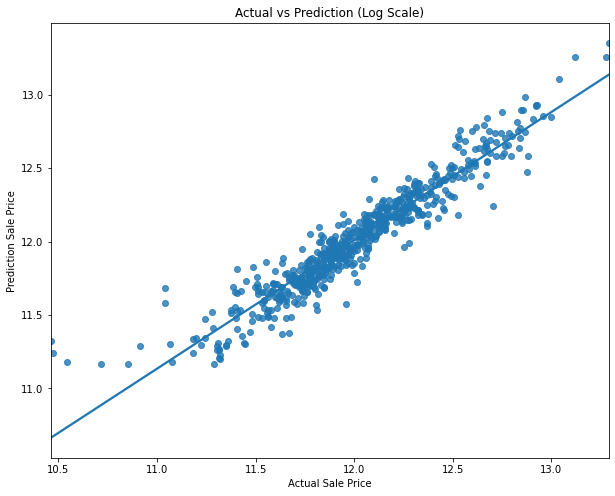

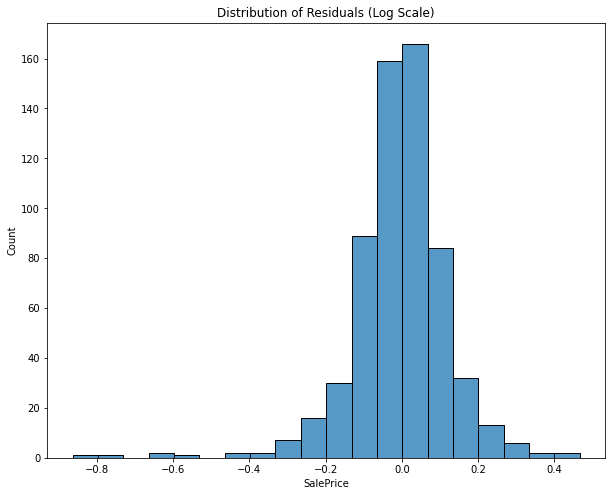

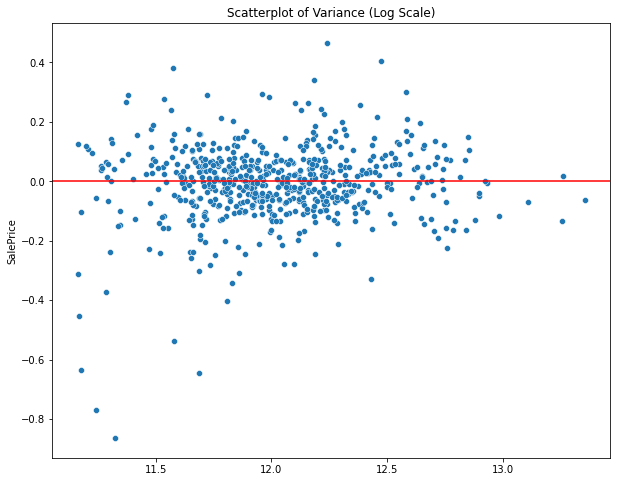

In [80]:
    # Same steps as above
    
    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=0.3, random_state=42)
    
    ss = StandardScaler()
    
    Z_train = ss.fit_transform(X_train)
    Z_test = ss.transform(X_test)
    
    enet_alphas = np.linspace(0.01,0.50,100)
    
    enet_ratio = 0.2469387755102041
    
    enet = ElasticNetCV(alphas = enet_alphas, l1_ratio = enet_ratio, cv=5)
    
    enet.fit(Z_train, y_train)
    
    enet_alpha = enet.alpha_
    enet_train_score = enet.score(Z_train, y_train)
    mse_train = metrics.mean_squared_error(y_train, enet.predict(Z_train))
    rmse_train = metrics.mean_squared_error(y_train, enet.predict(Z_train), squared=False)
    mse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(enet.predict(Z_train)))
    rmse_train_exp = metrics.mean_squared_error(np.exp(y_train), np.exp(enet.predict(Z_train)), squared=False)
       
    enet_test_score = enet.score(Z_test, y_test)
    mse_test = metrics.mean_squared_error(y_test, enet.predict(Z_test))
    rmse_test = metrics.mean_squared_error(y_test, enet.predict(Z_test), squared=False)
    mse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(enet.predict(Z_test)))
    rmse_test_exp = metrics.mean_squared_error(np.exp(y_test), np.exp(enet.predict(Z_test)), squared=False)
    
    Score_Summary_Enet = pd.DataFrame({'Metrics':['Alpha','R2','MSE','RMSE', 'MSE_exp','RMSE_exp'],
                                 'Train':[enet_alpha, enet_train_score, mse_train, rmse_train, mse_train_exp, rmse_train_exp],
                                 'Test':[enet_alpha, enet_test_score, mse_test, rmse_test, mse_test_exp, rmse_test_exp]})
    
    plt.figure(figsize=(10,8))
    sns.regplot(x=y_test, y=enet.predict(Z_test),ci=False)
    plt.title('Actual vs Prediction (Log Scale)')
    plt.xlabel(xlabel='Actual Sale Price')
    plt.ylabel(ylabel='Prediction Sale Price')

    resids_base = y_test - enet.predict(Z_test)
    plt.figure(figsize=(10,8))
    sns.histplot(resids_base, bins=20)
    plt.title('Distribution of Residuals (Log Scale)')

    plt.figure(figsize=(10,8))
    sns.scatterplot(x=enet.predict(Z_test), y=resids_base)
    plt.axhline(0, color='red')
    plt.title('Scatterplot of Variance (Log Scale)');
    

    Score_Summary_Enet    

In [81]:
# Coefficients for ElasticNet

Coefficient_Summary = pd.DataFrame(list(zip(X_2.columns, enet.coef_)), columns = ['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

Coefficient_Summary.head(10)

Feature  Coefficient
90    Year Remod/Add Gr Liv Area     0.064119
23                    Year Built     0.050675
60    Overall Cond TotRms AbvGrd     0.046812
54    Overall Qual Kitchen AbvGr     0.041043
131  BsmtFin Type 1 BsmtFin SF 1     0.033453
53    Overall Qual Total Bsmt SF     0.033046
58     Overall Qual has_basement     0.031678
62      Overall Cond Garage Area     0.023980
81            Year Built Yr Sold     0.023481
75        Year Built Gr Liv Area     0.023241

### Ridge, Lasso, ElasticNet Evaluation

I applied three linear models to help resolve my low bias, high variance effect and as well as to address multicolinearity within my features. In all three models, my results improved drastically across all metrics and all outperformed the baseline, which indicates the model is predicting with some high level of accuracy beyond just randomly picking predictions.

R2 scores between the train and test data were in close proximity, in the 0.2 range. MSE and RMSE metrics (both log and exponentiated) were pretty similar across all three models as well. There seems to be a pretty good balance between bias and variance as well given that while the metrics for the train data for all three models are higher, the difference isn't extreme. Models may be slightly overfit but given the model's performance prior to regularization, this is certainly a huge improvement.


Coefficients are harder to interpet given they have been scaled. However, the relationship to the target variable is still preserved and interpretable in terms of correlation strength. For instance, interative feature Year Remod/Add_Gr Liv Area has the highest coefficient of 0.06 followed by a series of other featuers related to either condition of the home, age of the home (when it was built), area/living space, and etc. These features seem to jive with common sense since factors like sq ft, number of bedrooms, quality of the home, age of the home are all important featuers that a typical homebuyer looks for.

Lastly, across all three models, assumptions required for linear regressions seem to be held. Linearity between some of the features and sale price has already been observed during EDA portion of the analysis. Independence is a bit subjective depending on how you look at it. While a sale price of one home doesn't necessary directly impact the sale price of another, there is usually some connection because real estate markets are evaluted based on proximity to certain locations (town/county, which street, school district, and etc.). However, for the purpose of this analysis, I think the independence assumption is reasonable to make. For normality of error, there is a fairly decent normal distribution of residuals.

One issue could be homoscedasticity. All three models seem to predict middle of the pack with more level of accuracy. While the presence of heteroscedasticity ceratinly does not mitigate the application of linear regression, it is an indication that there are still some fine-tuning that may be necessary.

### Conclusion and Recommendations

In this analysis, using the Ames housing prices data, I was able to build a linear regression model that can predict housing prices in Ames, Iowa with certain level of predictive power.

To set the stage for linear regression, I went through a round of feature selection and feature engineering to best strengthen signal and reduce noise.

I applied Ridge, Lasso, and ElasticNet to measure and compare their perfomance in R2, MSE, and RMSE. In terms of performance, Lasso performed the best with unseen test data. With Lasso, the model produced R2 score of 0.90 with unseen data. This essentially means that 90% of variability in sale prices around the mean can be explained based on features used in the model. To understand which features have the most significance, I found that the interactive term 'Gr Liv Area and Year Remod/Add' had the largest coefficient, followed by other interative terms related to the size, quality, age, and number of bedroom/bathrooms which seem to jive with common sense.


There are definitely additional room for improvements and enhancements. Here are some possible considerations that can help to increase performance and predictiability:

* Feature Engineering:
    
    - My feature selection and engineering process in this analysis was just one from many different options that I could have explored. Alternative route I could havek is to perhaps narrow down the list of feature early on in the process using a threshold such as R2 >0.50 but this required the assumption that other features with correlation less than 0.50 do not have predictive power when coupled with other features. I think it may be worth to revisit this assumption and try using a different thresholds early on in the process to potentially elminate noise as early as possible.


* Additional data:

    - There are many other features that could have been layered in outside of the data that was provided. Variables such as public safety of the neighborhood, public school ratings, environmental factors, property tax, and many others also contribute greatly to housing prices. By layering in industry-specific features, the model can definitely be improved and make better predictions.


* Ordinal variables:
    - I applied a hybrid approach with ordinal variables. Instead of convering all of them to numeric variables, I selectively chose only a handful or ordinal variables that I believed displayed "true" order in light of sale price. For others, I chose to conver tthem to dummy variables. To get more predictive power out of ordinal variables, perhaps I could have applied more industry-wide accpeted scale of rating rather than arbitrary choosing one. For instance, "Excellent" in the real estate market may carry more magnitute and impact and should weigh much more than "Good" or "Average". If there is a standarized scale that is used in the industry, that may have added more value and insight.
    
 
 * Generalization:
    - This model was created using housing prices data in Ames, Iowa. If I were to apply this model to predict housing prices in other geographic locations, this model most likely will not perform as well. To make the model scalable, it will require further data and complexity such as housing prices variance across different parts of the country, specific housing market trends, and etc. 
    
    
 * Heteroscedasticity:
    - There is an evidence of hereoscedasiticy across all three models. Ideally, the ideal goal would be to achieve homoscedasticity where there is equal variance of error across all predictions. While hereoscedasticy doesn't mitigate the usage of linear regression model, it is an indication that that are some more fine tuning that needs to be done. One potential recommendation here would be to explore which feature has a smilar behavior as the target variable in terms of skewedness and apply log transformation to account for those characteristics.
    
 
    
Lastly, for dsir-1019 Kaggle competition, my final submission of ElasticNet performed the best with RMSE score of 22,687.22.


### Submission Preparation

In [82]:
# Read the polished test data set

df = pd.read_csv('../datasets/test_polished_v2.csv')

In [83]:
df.head()

Unnamed: 0    Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  \
0           0  2658  902301120          190        RM     69.000000      9142   
1           1  2718  905108090           90        RL     69.545961      9662   
2           2  2414  528218130           60        RL     58.000000     17104   
3           3  1989  902207150           30        RM     60.000000      8520   
4           4   625  535105100           20        RL     69.545961      9500   

  Street     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
0   Pave      Grvl       Reg          Lvl    AllPub     Inside        Gtl   
1   Pave  No Alley       IR1          Lvl    AllPub     Inside        Gtl   
2   Pave  No Alley       IR1          Lvl    AllPub     Inside        Gtl   
3   Pave  No Alley       Reg          Lvl    AllPub     Inside        Gtl   
4   Pave  No Alley       IR1          Lvl    AllPub     Inside        Gtl   

  Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
0      OldTown        Norm        Norm    2fmCon      2Story             6   
1       Sawyer        Norm        Norm    Duplex      1Story             5   
2      Gilbert        Norm        Norm      1Fam      2Story             7   
3      OldTown        Norm        Norm      1Fam      1Story             5   
4        NAmes        Norm        Norm      1Fam      1Story             6   

   Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
0             8        1910            1950      Gable   CompShg      AsbShng   
1             4        1977            1977      Gable   CompShg      Plywood   
2             5        2006            2006      Gable   CompShg      VinylSd   
3             6        1923            2006      Gable   CompShg      Wd Sdng   
4             5        1963            1963      Gable   CompShg      Plywood   

  Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual Exter Cond Foundation  \
0      AsbShng         None           0.0           6         Fa      Stone   
1      Plywood         None           0.0           6         TA     CBlock   
2      VinylSd         None           0.0           4         TA      PConc   
3      Wd Sdng         None           0.0           4         TA     CBlock   
4      Plywood      BrkFace         247.0           6         TA     CBlock   

   Bsmt Qual Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
0          4        TA              1               1             0   
1          4        TA              1               1             0   
2          4        Gd              3              10           554   
3          6        TA              1               1             0   
4          4        TA              1               6           609   

  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF Heating  \
0            Unf             0         1020           1020    GasA   
1            Unf             0         1967           1967    GasA   
2            Unf             0          100            654    GasA   
3            Unf             0          968            968    GasA   
4            Unf             0          785           1394    GasA   

   Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  \
0           4           N      FuseP         908        1020                0   
1           6           Y      SBrkr        1967           0                0   
2          10           Y      SBrkr         664         832                0   
3           6           Y      SBrkr         968           0                0   
4           4           Y      SBrkr        1394           0                0   

   Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  \
0         1928               0               0          2          0   
1         1967               0               0          2          0   
2         1496               1               0          2          1   

In [84]:
# Drop unnamed columns

df.drop(columns=['Unnamed: 0'], inplace=True)

In [85]:
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM     69.000000      9142   Pave   
1  2718  905108090           90        RL     69.545961      9662   Pave   
2  2414  528218130           60        RL     58.000000     17104   Pave   
3  1989  902207150           30        RM     60.000000      8520   Pave   
4   625  535105100           20        RL     69.545961      9500   Pave   

      Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
0      Grvl       Reg          Lvl    AllPub     Inside        Gtl   
1  No Alley       IR1          Lvl    AllPub     Inside        Gtl   
2  No Alley       IR1          Lvl    AllPub     Inside        Gtl   
3  No Alley       Reg          Lvl    AllPub     Inside        Gtl   
4  No Alley       IR1          Lvl    AllPub     Inside        Gtl   

  Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
0      OldTown        Norm        Norm    2fmCon      2Story             6   
1       Sawyer        Norm        Norm    Duplex      1Story             5   
2      Gilbert        Norm        Norm      1Fam      2Story             7   
3      OldTown        Norm        Norm      1Fam      1Story             5   
4        NAmes        Norm        Norm      1Fam      1Story             6   

   Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl Exterior 1st  \
0             8        1910            1950      Gable   CompShg      AsbShng   
1             4        1977            1977      Gable   CompShg      Plywood   
2             5        2006            2006      Gable   CompShg      VinylSd   
3             6        1923            2006      Gable   CompShg      Wd Sdng   
4             5        1963            1963      Gable   CompShg      Plywood   

  Exterior 2nd Mas Vnr Type  Mas Vnr Area  Exter Qual Exter Cond Foundation  \
0      AsbShng         None           0.0           6         Fa      Stone   
1      Plywood         None           0.0           6         TA     CBlock   
2      VinylSd         None           0.0           4         TA      PConc   
3      Wd Sdng         None           0.0           4         TA     CBlock   
4      Plywood      BrkFace         247.0           6         TA     CBlock   

   Bsmt Qual Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
0          4        TA              1               1             0   
1          4        TA              1               1             0   
2          4        Gd              3              10           554   
3          6        TA              1               1             0   
4          4        TA              1               6           609   

  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF Heating  \
0            Unf             0         1020           1020    GasA   
1            Unf             0         1967           1967    GasA   
2            Unf             0          100            654    GasA   
3            Unf             0          968            968    GasA   
4            Unf             0          785           1394    GasA   

   Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  \
0           4           N      FuseP         908        1020                0   
1           6           Y      SBrkr        1967           0                0   
2          10           Y      SBrkr         664         832                0   
3           6           Y      SBrkr         968           0                0   
4           4           Y      SBrkr        1394           0                0   

   Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  \
0         1928               0               0          2          0   
1         1967               0               0          2          0   
2         1496               1               0          2          1   
3          968               0               0          1          0   
4

In [86]:
# Create a dataframe for Kaggle Submission (ID is required)

submission = pd.DataFrame()
submission['Id'] = df['Id']

In [87]:
submission.head()

Id
0  2658
1  2718
2  2414
3  1989
4   625

In [88]:
# Select features required for my model

X_kgl = df[xvars]

In [89]:
X_kgl

Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
0       69.000000      9142             6             8        1910   
1       69.545961      9662             5             4        1977   
2       58.000000     17104             7             5        2006   
3       60.000000      8520             5             6        1923   
4       69.545961      9500             6             5        1963   
..            ...       ...           ...           ...         ...   
873     80.000000      8000             6             6        1974   
874     90.000000     14670             6             7        1966   
875     55.000000      8250             5             5        1968   
876     60.000000      9000             4             6        1971   
877     70.000000      8400             5             5        1955   

     Year Remod/Add  Mas Vnr Area  Exter Qual  Bsmt Qual  Bsmt Exposure  \
0              1950           0.0           6          4              1   
1              1977           0.0           6          4              1   
2              2006           0.0           4          4              3   
3              2006           0.0           4          6              1   
4              1963         247.0           6          4              1   
..              ...           ...         ...        ...            ...   
873            1974           0.0           6          6              1   
874            1999         410.0           4          6              1   
875            1968           0.0           6          6              1   
876            1971           0.0           6          6              1   
877            1955           0.0           6          6              1   

     BsmtFin Type 1  BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
0                 1             0             0         1020           1020   
1                 1             0             0         1967           1967   
2                10           554             0          100            654   
3                 1             0             0          968            968   
4                 6           609             0          785           1394   
..              ...           ...           ...          ...            ...   
873               8           931           153            0           1084   
874               6           575             0          529           1104   
875               6           250           492          210            952   
876               8           616             0          248            864   
877               6           793             0          130            923   

     Heating QC  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
0             4         908        1020                0         1928   
1             6        1967           0                0         1967   
2            10         664         832                0         1496   
3             6         968           0                0          968   
4             4        1394           0                0         1394   
..          ...         ...         ...              ...          ...   
873           6        1084         793                0         1877   
874          10        1104         884                0         1988   
875          10        1211           0                0         1211   
876           6         864           0                0          864   
877           6         925           0                0          925   

     Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
0                 0               0          2          0              4   
1                 0               0          2          0              6   
2                 1               0          2          1              3   
3                 0               0          1          0              2   
4                 1               0          

In [90]:
# Apply feature engineering

poly_kgl = PolynomialFeatures(include_bias=False)

X_kgl_poly = poly_kgl.fit_transform(X_kgl)

In [91]:
# Set it as a variable

X_kgl_poly_set = pd.DataFrame(X_kgl_poly, columns = poly_kgl.get_feature_names(xvars))

In [92]:
X_kgl_poly_set.shape

(878, 1274)

In [93]:
# Pick out categorical features and set it as a variable

X_kgl_dummy = df[none_numeric_columns]

In [94]:
# Create dummy variables

X_kgl_dummy = pd.get_dummies(X_kgl_dummy, columns=none_numeric_columns, drop_first=True)

In [95]:
# Concat feature engineered and dummified sets together

X_kgl = pd.concat([X_kgl_poly_set, X_kgl_dummy], axis=1)

In [96]:
# Ensure the test data has these features.

model_columns = list(X_2.columns)

In [97]:
X_2.shape

(2047, 384)

In [98]:
# Confirm features then set it as a variable

X_kgl = X_kgl[model_columns]

In [99]:
X_kgl.head()

Neighborhood_Edwards  Neighborhood_MeadowV  Neighborhood_NAmes  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   1   

   Neighborhood_SWISU  Condition 1_Feedr  Condition 1_Norm  Condition 1_PosA  \
0                   0                  0                 1                 0   
1                   0                  0                 1                 0   
2                   0                  0                 1                 0   
3                   0                  0                 1                 0   
4                   0                  0                 1                 0   

   Condition 1_PosN  Exterior 1st_AsphShn  Exterior 1st_BrkComm  \
0                 0                     0                     0   
1                 0                     0                     0   
2                 0                     0                     0   
3                 0                     0                     0   
4                 0                     0                     0   

   Exter Cond_Fa  Exter Cond_Gd  Exter Cond_TA  Foundation_CBlock  \
0              1              0              0                  0   
1              0              0              1                  1   
2              0              0              1                  0   
3              0              0              1                  1   
4              0              0              1                  1   

   Foundation_PConc  Foundation_Stone  Heating_Grav  Garage Qual_Po  \
0                 0                 1             0               1   
1                 0                 0             0               0   
2                 1                 0             0               0   
3                 0                 0             0               0   
4                 0                 0             0               0   

   Paved Drive_Y  Pool QC_TA  Sale Type_Con  Sale Type_New  Sale Type_WD   \
0              1           0              0              0              1   
1              1           0              0              0              1   
2              1           0              0              1              0   
3              0           0              0              0              1   
4              1           0              0              0              1   

   Year Built  Heating QC  Bsmt Full Bath  Bsmt Half Bath  Garage Yr Blt  \
0      1910.0         4.0             0.0             0.0         1910.0   
1      1977.0         6.0             0.0             0.0         1977.0   
2      2006.0        10.0             1.0             0.0         2006.0   
3      1923.0         6.0             0.0             0.0         1935.0   
4      1963.0         4.0             1.0             0.0         1963.0   

   3Ssn Porch  Pool Area  has_garage  has_pool  Lot Frontage BsmtFin SF 1  \
0         0.0        0.0         1.0       0.0                   0.000000   
1         0.0        0.0         1.0       0.0                   0.000000   
2         0.0        0.0         1.0       0.0               32132.000000   
3         0.0        0.0         1.0       0.0                   0.000000   
4         0.0        0.0         1.0       0.0               42353.490251   

   Lot Frontage BsmtFin SF 2  Lot Frontage Bsmt Unf SF  \
0                        0.0              70380.000000   
1                        0.0             136796.905292   
2                        0.0               5800.000000   
3                        0.0              58080.000000   
4                        0.0              54593.579387   

   Lot Frontage Total Bsmt SF  Lot Frontage Pool Area  Lot Frontage has_pool  \
0                70380.000000                     

In [100]:
# Scale the data

ss = StandardScaler()
Z_kgl = ss.fit_transform(X_kgl)

In [101]:
Z_kgl.shape

(878, 384)

In [107]:
Z_train.shape

(1432, 384)

In [112]:
# Save ridge predictions

enet_preds = enet.predict(Z_kgl)

In [113]:
# Exponentiate and add it to submission dataframe

submission['SalePrice'] = np.exp(enet_preds)

In [114]:
submission.head()

Id      SalePrice
0  2658  131829.422090
1  2718  168582.942072
2  2414  211789.535503
3  1989  105010.708921
4   625  173260.231136

In [115]:
# Export as csv

submission.to_csv('../datasets/Kaggle Submission - Final/yp_submission_enet_final.csv', index=False)